# Loan Data from Prosper 
by Olga Timofeeva


This document explores the Loan Data from Prosper containing prices and attributes for approximately 113,936 loans.
The dataset was last updated on 03/11/2014.

However, the data set will be wrangled and cleaned for this project in section 1.3 Preliminary Wrangling to select only loans where Prosper Score is available.

The data wrangling will result in 77557 loans in the final data set for exploration.


## Preliminary Wrangling

> Next step is loading in the dataset and describing its properties through code cells below. This section will facilitate exploration goals.


### Library Import

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import ast
import math

%matplotlib inline

### Function Definitions

Below there are few functions that will help with wrangling Prosper dataset before explaratory  and explanatory analysis begins.

In [2]:
def loan_status_simplifier(row):
    """
    This function decodes `LoanStatus` value to `Past Due` for the statuses starting with `Past Due`.  
    @param: row - dataframe row to get `LoanStatus` value
    @return: same value as `Loan Status` except for the values starting  with `Past Due`.
    """
    loan_status = str(row['LoanStatus'])
    past_statuses = ['Past Due (>120 days)', 'Past Due (91-120 days)', 'Past Due (61-90 days)',
                     'Past Due (31-60 days)','Past Due (16-30 days)', 'Past Due (1-15 days)']
    if loan_status in past_statuses:
        return 'Past Due'
    else: return loan_status

In [3]:
def create_common_rating(row):
    """
    This function creates a loan rating value with taking `CreditGrade` 
    for loans originated before July 2009,
    and `ProsperRating (Alpha)` values for loans originated after July 2009.
    
    @param: row - loans dataframe row
    @return: derived rating value
    """
    credtit_grade = str(row['CreditGrade'])
    prosper_alpha_rating = str(row['ProsperRating (Alpha)'])
    if len(prosper_alpha_rating) and prosper_alpha_rating !='nan':
        return prosper_alpha_rating
    elif len(credtit_grade) and credtit_grade !='nan':
        return credtit_grade
    else:
        return 'HR'

In [4]:
def create_term_years(row):
    """
    This function calculates term of a loan in years
    @param: row - loans dataframe row to derive `Term` value
    @return: term in years concatinated with 'Y' literal
    """
    term_months = pd.to_numeric(row['Term'])
    return str(int(term_months / 12)) + 'Y'

In [5]:
def round_monthly_income(row):
    """
    This functions rounds monthly income as it was required for calculating bins for plotting
    @param: row - loans dataframe row to derive `StatedMonthlyIncome` value
    @return: rounded 'StatedMonthlyIncome' as int
    """
    income = pd.to_numeric(row['StatedMonthlyIncome'])
    return int(income)

In [6]:
# compute the logarithm of price to make multivariate plotting easier
def log_trans(x, inverse = False):
    """ 
    quick function for computing log and power operations with base of 10
    @param: x - value to compute exponent or log
    @param: inverse: False for log(x) with base 10, True for 10^x function
    @return: log(x) with base 10 if inverse = False; 10^x if inverse=True 
    """
    if not inverse:
        return np.log10(x)
    else:
        return np.power(10, x)



In [7]:
def transform_listing_category(row):
    """
    This function decodes listing category (numeric) value to human readable value
    as per Prosper data defintion
    
    @param: row - loans dataframe row
    @return: decoded listing category as a string human readable value
    """
    loan_category_dict = {'0':'Not Available', '1':'Debt Consolidation', '2':'Home Improvement', '3':'Business',
                          '4':'Personal Loan', '5':'Student Use', '6':'Auto', '7':'Other', '8':'Baby&Adoption',
                          '9':'Boat', '10':'Cosmetic Procedure', '11':'Engagement Ring', '12':'Green Loans',
                          '13':'Household Expenses', '14':'Large Purchases',
                          '15':'Medical/Dental', '16':'Motorcycle', '17':'RV', '18':'Taxes',
                          '19':'Vacation', '20':'Wedding Loans'}
    loan_category_numeric = str(row['ListingCategory (numeric)'])
    if loan_category_numeric == 'nan':
        return 'Not Available'
    return loan_category_dict[loan_category_numeric]
    

In [8]:
def countplot_categorical_frequencies(df, col, figsize_params, title, xticks_rotation):
    """
    @param: df - dataframe with the specified colummn `col`
    @param: col - the column that will be plotted with relative frequencies
    @param: figsize_params - matplotlib figure size
    @param: title - title for the plot
    @param: xticks_rotation - specify rotation param for xticks
    """
    # calculate counts first
    col_counts = df[col].value_counts()
    counts_order = col_counts.index
    total = df[col].value_counts().sum()
    
    if col =='ProsperScore' or col=='ProsperRating (numeric)':
        #print(col_counts)
        col_counts.index = col_counts.index.astype(str, copy = False)
    #plot ctaegorical variable distribution with frequency labels
    fig, ax = plt.subplots(figsize = figsize_params)

    default_color = sb.color_palette()[0]
    sb.countplot(data = df, x = col, color = default_color)
    plt.title(title);

    # get the current tick locations and labels
    locs, labels = plt.xticks(rotation=xticks_rotation) 
    # loop through each pair of locations and labels
    for loc, label in zip(locs, labels):

        # get the text property for the label to get the correct count
        #x_label = ast.literal_eval(label.get_text())
        x_label = label.get_text()
        if x_label == 'True':
            count = col_counts[True]
        elif x_label == 'False':
            count = col_counts[False]
        else:    
            count = col_counts[x_label]
        
        if total > 0:
            pct_string = '{:0.4f}%'.format(100*count/total)
        else:
            pct_string = '{:0.4f}%'.format(0)
        # print the annotation just below the top of the bar
        #top_margin = math.sqrt(figsize_params[0])
        top_margin = (figsize_params[0]**1/3)
        plt.text(loc, count+100*top_margin, pct_string, ha = 'center', color = 'black')

In [9]:
def hist2dgrid(x, y, **kwargs):
    """ 
    Quick hack for creating heat maps with seaborn's PairGrid. 
    This function was provided in the Udacity Diamonds Case Study
    """
    palette = kwargs.pop('color')
    bins_x = np.arange(0.0, 0.36+.05, .05)
    bins_y = np.arange(2.5, 4.6+0.3, 0.3)
    plt.hist2d(x, y, bins = [bins_x, bins_y], cmap = palette, cmin = 0.5)
    plt.yticks(log_trans(np.array([500, 1e3 ,2e3, 4e3, 6e3, 1e4, 2e4, 3e4,9e4])),
               [500, '1k', '2k', '5k', '10k', '20k', '30k', '90k']);

In [10]:
# load in the dataset into a pandas dataframe, print statistics
loans = pd.read_csv('prosperLoanData.csv')

In [11]:
# high-level overview of data shape and composition
print(loans.shape)
print(loans.dtypes)
print(loans.head(10))

(113937, 81)
ListingKey                      object
ListingNumber                    int64
ListingCreationDate             object
CreditGrade                     object
Term                             int64
                                ...   
PercentFunded                  float64
Recommendations                  int64
InvestmentFromFriendsCount       int64
InvestmentFromFriendsAmount    float64
Investors                        int64
Length: 81, dtype: object
                ListingKey  ListingNumber            ListingCreationDate  \
0  1021339766868145413AB3B         193129  2007-08-26 19:09:29.263000000   
1  10273602499503308B223C1        1209647  2014-02-27 08:28:07.900000000   
2  0EE9337825851032864889A          81716  2007-01-05 15:00:47.090000000   
3  0EF5356002482715299901A         658116  2012-10-22 11:02:35.010000000   
4  0F023589499656230C5E3E2         909464  2013-09-14 18:38:39.097000000   
5  0F05359734824199381F61D        1074836  2013-12-14 08:26:37.093000000   


In [12]:
# list all columns of the dataset to overview 
# which loan attributes can influence loan outcome
loans.columns

Index(['ListingKey', 'ListingNumber', 'ListingCreationDate', 'CreditGrade',
       'Term', 'LoanStatus', 'ClosedDate', 'BorrowerAPR', 'BorrowerRate',
       'LenderYield', 'EstimatedEffectiveYield', 'EstimatedLoss',
       'EstimatedReturn', 'ProsperRating (numeric)', 'ProsperRating (Alpha)',
       'ProsperScore', 'ListingCategory (numeric)', 'BorrowerState',
       'Occupation', 'EmploymentStatus', 'EmploymentStatusDuration',
       'IsBorrowerHomeowner', 'CurrentlyInGroup', 'GroupKey',
       'DateCreditPulled', 'CreditScoreRangeLower', 'CreditScoreRangeUpper',
       'FirstRecordedCreditLine', 'CurrentCreditLines', 'OpenCreditLines',
       'TotalCreditLinespast7years', 'OpenRevolvingAccounts',
       'OpenRevolvingMonthlyPayment', 'InquiriesLast6Months', 'TotalInquiries',
       'CurrentDelinquencies', 'AmountDelinquent', 'DelinquenciesLast7Years',
       'PublicRecordsLast10Years', 'PublicRecordsLast12Months',
       'RevolvingCreditBalance', 'BankcardUtilization',
       'Availa

In [13]:
# define dictionary to fill in null values for the columns that may influence loan status
na_dict = {'Occupation':'Other', 
           'EmploymentStatus':'Not available',
           'BorrowerState':'Not Available'}
# fill null values in prosper dataset with the values as per the dictionary above
loans.fillna(na_dict, inplace=True)

In [14]:
# convert timestamp columns to datetime type
datetime_cols =['LoanOriginationDate', 'ListingCreationDate', 'ClosedDate']
for col in datetime_cols:
    loans[col] = pd.to_datetime(loans[col])

In [15]:
# convert loan categories from numeric to human readeable string value as per Prosper defintion
loans['LoanCategory'] = loans.apply(lambda row: transform_listing_category(row), axis =1)
loan_categories = ['Not Available', 'Home Improvement', 'Motorcycle',
       'Debt Consolidation', 'Other', 'Household Expenses', 'Auto',
       'Medical/Dental', 'Wedding Loans', 'Vacation', 'Business', 'Taxes',
       'Baby&Adoption', 'Personal Loan', 'Engagement Ring',
       'Large Purchases', 'Student Use', 'Boat', 'RV',
       'Cosmetic Procedure', 'Green Loans']
loan_categories.sort(key=str.lower)
loan_category = pd.api.types.CategoricalDtype(ordered = False, categories = loan_categories)
loans['LoanCategory'] = loans['LoanCategory'].astype(loan_category)
# list value counts for newly created 'LoanCategory' column:
loans['LoanCategory'].value_counts()

Debt Consolidation    58308
Not Available         16965
Other                 10494
Home Improvement       7433
Business               7189
Auto                   2572
Personal Loan          2395
Household Expenses     1996
Medical/Dental         1522
Taxes                   885
Large Purchases         876
Wedding Loans           771
Vacation                768
Student Use             756
Motorcycle              304
Engagement Ring         217
Baby&Adoption           199
Cosmetic Procedure       91
Boat                     85
Green Loans              59
RV                       52
Name: LoanCategory, dtype: int64

In [16]:
# decode all loan statuses starting with 'Past Due' as a single 'Past Due' value in a new column: 
loans['LoanStatusSimplified'] = loans.apply(lambda row: loan_status_simplifier(row), axis =1 )
# list value counts in the new column 'LoanStatusSimplified'  
loans['LoanStatusSimplified'].value_counts()

Current                   56576
Completed                 38074
Chargedoff                11992
Defaulted                  5018
Past Due                   2067
FinalPaymentInProgress      205
Cancelled                     5
Name: LoanStatusSimplified, dtype: int64

In [17]:
# do not need it anymore
#create a new column that calculates loan rating for all loans taking:
# CreditGrade for loans originated before July 2009
# Prosper Rating for loans originated after July 2009
loans['LoanRating'] = loans.apply(lambda row: create_common_rating(row), axis = 1)

In [18]:
# print value counts of the newly created column 'LoanRating'
loans['LoanRating'].value_counts()

C     23994
B     19970
D     19427
A     17866
E     13084
HR    10574
AA     8881
NC      141
Name: LoanRating, dtype: int64

In [19]:
# evidence that there are no null value
loans['LoanRating'].isna().sum()

0

In [20]:
# list value counts of 'ProsperScore'. 
# Note that values are populated for loans originated after July 2009
loans['ProsperScore'].value_counts()

4.0     12595
6.0     12278
8.0     12053
7.0     10597
5.0      9813
3.0      7642
9.0      6911
2.0      5766
10.0     4750
11.0     1456
1.0       992
Name: ProsperScore, dtype: int64

In [21]:
# print how many loans have null 'ProsperScore'. 
loans['ProsperScore'].isna().sum()

29084

In [22]:
# list value counts of 'ProsperRating (Alpha)'.
loans['ProsperRating (Alpha)'].value_counts()

C     18345
B     15581
A     14551
D     14274
E      9795
HR     6935
AA     5372
Name: ProsperRating (Alpha), dtype: int64

In [23]:
# print how many loans have null 'ProsperRating (Alpha)'. 
loans['ProsperRating (Alpha)'].isna().sum()

29084

In [24]:
# print value counts of 'ProsperRating (numeric)' column. 
loans['ProsperRating (numeric)'].value_counts()

4.0    18345
5.0    15581
6.0    14551
3.0    14274
2.0     9795
1.0     6935
7.0     5372
Name: ProsperRating (numeric), dtype: int64

In [25]:
# print how many loans have null 'ProsperRating (numeric)'. 
loans['ProsperRating (numeric)'].isna().sum()

29084

In [26]:
# print unique values of 'IncomeRange' column
loans['IncomeRange'].unique()

array(['$25,000-49,999', '$50,000-74,999', 'Not displayed', '$100,000+',
       '$75,000-99,999', '$1-24,999', 'Not employed', '$0'], dtype=object)

In [27]:
# split Loan quater and year in two seaparate columns:
loans[['LoanQuarter', 'LoanYear']] = loans.LoanOriginationQuarter.str.split(expand=True)

In [28]:
# create a new column 'TermYears' to calculate a categorical value for loan term as
# loan term in years concatenated with literal 'Y'
loans['TermYears'] = loans.apply(lambda row: create_term_years(row), axis = 1)

In [29]:
# create a column with log of loan amount
# this will be used in multivariate exploration
loans['log_loan_amt'] = loans['LoanOriginalAmount'].apply(log_trans)

In [30]:
# since the variables of interest shall have values to analyse, we need to filter our dataframe
# to have rows that have following columns with not null values:
filtered_loans = loans[loans['DebtToIncomeRatio'].notnull() &
                       loans['DelinquenciesLast7Years'].notnull() &
                       loans['BankcardUtilization'].notnull() &
                       loans['BorrowerRate'].notnull() &
                       loans['ProsperScore'].notnull()
                      ]

In [31]:
# list columns that will be left in the trimmed data set
# for exploration and explonatory analysis
loans_columns_of_interest = ['log_loan_amt', 'TermYears',
'LoanStatusSimplified','BorrowerRate',
'ProsperRating (numeric)', 'ProsperScore', 'ProsperRating (Alpha)',
'LoanCategory','BorrowerState','Occupation',
'EmploymentStatus','IsBorrowerHomeowner', 
'IncomeVerifiable','StatedMonthlyIncome', 'LoanOriginalAmount',
'DelinquenciesLast7Years', 'BankcardUtilization',
'DebtToIncomeRatio', 'IncomeRange']

In [32]:
# leave only columns that will be used in the further analysis
loans_cleared = pd.DataFrame(filtered_loans[loans_columns_of_interest])

In [33]:
# perform a quick check on loan status ('LoanStatusSimplified') value counts
loans_cleared['LoanStatusSimplified'].value_counts()

Current                   52478
Completed                 17703
Chargedoff                 4445
Past Due                   1857
Defaulted                   885
FinalPaymentInProgress      189
Name: LoanStatusSimplified, dtype: int64

In [34]:
# have a look at the resultant dataset to identify data issues such as null values:
loans_cleared.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 77557 entries, 1 to 113936
Data columns (total 19 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   log_loan_amt             77557 non-null  float64 
 1   TermYears                77557 non-null  object  
 2   LoanStatusSimplified     77557 non-null  object  
 3   BorrowerRate             77557 non-null  float64 
 4   ProsperRating (numeric)  77557 non-null  float64 
 5   ProsperScore             77557 non-null  float64 
 6   ProsperRating (Alpha)    77557 non-null  object  
 7   LoanCategory             77557 non-null  category
 8   BorrowerState            77557 non-null  object  
 9   Occupation               77557 non-null  object  
 10  EmploymentStatus         77557 non-null  object  
 11  IsBorrowerHomeowner      77557 non-null  bool    
 12  IncomeVerifiable         77557 non-null  bool    
 13  StatedMonthlyIncome      77557 non-null  float64 
 14  LoanO

In [35]:
loans_cleared['ProsperRating (Alpha)'].isna().sum()

0

> Note: There is significant amount of loans originated before July 2009 that does not have Prosper Score and Prosper Rating.
> It is probably worth to reduce the resultant dataset further as we will investigate reliance of Prosper Score and Prosper Rating on the loan outcome

In [36]:
# define categorical variables of interest that may influence a loan outcome
categorical_columns = ['TermYears', 'LoanStatusSimplified', 'ProsperRating (Alpha)', 'BorrowerState', 'Occupation',
                      'EmploymentStatus', 'IncomeRange']
for col in categorical_columns:
    print(col, loans_cleared[col].unique())

TermYears ['3Y' '5Y' '1Y']
LoanStatusSimplified ['Current' 'Past Due' 'Defaulted' 'Completed' 'Chargedoff'
 'FinalPaymentInProgress']
ProsperRating (Alpha) ['A' 'D' 'B' 'E' 'C' 'AA' 'HR']
BorrowerState ['CO' 'GA' 'MN' 'NM' 'KS' 'CA' 'IL' 'MD' 'AL' 'AZ' 'VA' 'FL' 'PA' 'OR'
 'NY' 'LA' 'WI' 'OH' 'NC' 'MI' 'WA' 'NV' 'NJ' 'TX' 'AR' 'SC' 'DE' 'UT'
 'DC' 'MA' 'MO' 'CT' 'IN' 'KY' 'OK' 'MS' 'RI' 'TN' 'WV' 'ID' 'HI' 'NH'
 'NE' 'WY' 'AK' 'MT' 'VT' 'SD']
Occupation ['Professional' 'Skilled Labor' 'Executive' 'Sales - Retail' 'Laborer'
 'Food Service' 'Fireman' 'Construction' 'Computer Programmer' 'Other'
 'Sales - Commission' 'Retail Management' 'Engineer - Mechanical'
 'Military Enlisted' 'Clerical' 'Teacher' 'Clergy' 'Attorney' 'Nurse (RN)'
 'Accountant/CPA' 'Analyst' 'Flight Attendant' 'Nurse (LPN)'
 'Military Officer' 'Administrative Assistant'
 'Police Officer/Correction Officer' 'Social Worker'
 'Food Service Management' 'Truck Driver' 'Tradesman - Mechanic'
 'Medical Technician' 'Professor'

In [37]:
# convert categorical variables into ordered categorical types
ordinal_var_dict = {'LoanStatusSimplified': ['Defaulted', 'Chargedoff','Past Due',
                                             'Cancelled', 'Current', 'FinalPaymentInProgress',
                                             'Completed'],
                    'TermYears': ['1Y', '3Y', '5Y'],
                    'ProsperRating (Alpha)': ['HR','E','D','C','B','A','AA'],
                    'EmploymentStatus': ['Other', 'Not employed', 'Retired', 'Part-time',
                                         'Self-employed','Employed', 'Full-time'],
                    'IncomeRange': ['Not employed', 'Not displayed', '$0', '$1-24,999', 
                                    '$25,000-49,999', '$50,000-74,999', '$75,000-99,999',
                                     '$100,000+']
                   }

for var in ordinal_var_dict:
    ordered_var = pd.api.types.CategoricalDtype(ordered = True,
                                                categories = ordinal_var_dict[var])
    loans_cleared[var] = loans_cleared[var].astype(ordered_var)

In [38]:
# this is additional data set for multi-variate exploration where the cancelled loan 
# was creating a plotting issue for the facet grid and hsitogram
# hence a new dataframe was created
statuses = ['Chargedoff','Defaulted', 'Past Due', 'Current', 'FinalPaymentInProgress','Completed']
loans_except_cancelled = pd.DataFrame(
    loans_cleared[(loans_cleared['LoanStatusSimplified'].isin(statuses))])
loans_except_cancelled.reset_index(drop=True)
loans_except_cancelled.LoanStatusSimplified.cat.remove_unused_categories(inplace=True)

In [39]:
loans_except_cancelled['LoanStatusSimplified'].value_counts()

Current                   52478
Completed                 17703
Chargedoff                 4445
Past Due                   1857
Defaulted                   885
FinalPaymentInProgress      189
Name: LoanStatusSimplified, dtype: int64

In [40]:
# print final data set columns information
loans_except_cancelled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 77557 entries, 1 to 113936
Data columns (total 19 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   log_loan_amt             77557 non-null  float64 
 1   TermYears                77557 non-null  category
 2   LoanStatusSimplified     77557 non-null  category
 3   BorrowerRate             77557 non-null  float64 
 4   ProsperRating (numeric)  77557 non-null  float64 
 5   ProsperScore             77557 non-null  float64 
 6   ProsperRating (Alpha)    77557 non-null  category
 7   LoanCategory             77557 non-null  category
 8   BorrowerState            77557 non-null  object  
 9   Occupation               77557 non-null  object  
 10  EmploymentStatus         77557 non-null  category
 11  IsBorrowerHomeowner      77557 non-null  bool    
 12  IncomeVerifiable         77557 non-null  bool    
 13  StatedMonthlyIncome      77557 non-null  float64 
 14  LoanO

### What is the structure of your dataset?

There are 77557 loans in the data set after data wrangling. 

There is significant amount of loans originated before July 2009 that does not have Prosper Score and Prosper Rating. This is the reason of reduction the initial dataset as the analysis below will investigate reliance of Prosper Score and Prosper Rating on the loan outcome.

It was my choice not to compute missing values but rather filter out records with missing values for `ProsperScore`, `BankcardUtilization`, `DebtToIncomeRatio`,  , and `DelinquenciesLast7Years` columns. Leaving missing values was not a good option either as it could skew the analysis.


In addition, the canceled loan after all data tidying was removed because it was the only 1 loan in this status and it caused facet grid plotting issues.

The resultant dataset contains 19 features, however the analysis focus will be focused on these:
* categorical variables
    * ProsperRating (Alpha)
    * ProsperRating (numeric) - also used as numeric variable for some plots
    * Loan Category
    * Loan status as `LoanStatusSimplified` - computed variable from original dataframe (converted from `LoanStatus`)
    * EmploymentStatus
    * BorrowerState - not much contribution - is it in bivariate analysis?
    * Occupation
    * State
        
* numerical variables
    * Prosper Score (arguably a categorical variable)
    * ProsperRating (numeric) - (arguably a categorical variable)
    * BorrowerRate
    * StatedMonthlyIncome
    * LoanOriginalAmount
    * DelinquenciesLast7Years
    * BankcardUtilization
    * DebtToIncomeRatio
    * log_loan_amount - a helper variable created during data wrangling stage that contain a log of original loan amount (base 10). It is only needed for the plotting later


Most variables are numeric in nature, but the variables below are ordered factor variables with the following levels from worst to best or small to great:
    * ProsperRating (Alpha) : 'HR','E','D','C','B','A','AA'
    * LoanStatusSimplified: 'Chargedoff','Defaulted', 'Past Due', 'Current', 'FinalPaymentInProgress','Completed'
    * EmploymentStatus: 'Other', 'Not employed', 'Retired', 'Part-time','Self-employed','Employed', 'Full-time'
    * Loan Category - not an ordinal categorical variable
    * Occupation - not an ordinal categorical variable
    * State - not an ordinal categorical variable for this project (maybe a good idea to sort alphabetically?)
 
        
### What is/are the main feature(s) of interest in your dataset?

I'm mostly interested in figuring out how reliable is Prosper scoring and loan ratings for predicting a loan outcome, and whether there are factors that can predict a borrower who is likely default or delay the payment.


### What features in the dataset do you think will help support your investigation into your feature(s) of interest?

> I expect that`ProsperScore`, `ProsperRating (numeric)` and `ProsperRating (Alpha)` shall be adequate indicators of successful loan outcome.
> I also expect that these variables can be used as factors for predicting loan outcome:
* Loan Category
* BorrowerRate
* Debt-to-income ratio
* EmploymentStatus
* StatedMonthlyIncome
* LoanOriginalAmount
* DebtToIncomeRatio


I think it is also worth to have a look at the variables below in order to get understanding how the `ProsperScore` and `ProsperRating (Alpha)` could be influenced by:
* BankcardUtilization,
* DelinquenciesLast7Years
* BorrowerState
* IsBorrowerHomeowner
* IncomeVerifiable


I will also have a look at consistency among rating and scoring variables:
* `ProsperScore`
* `ProsperRating (Alpha)`
* `ProsperRating (numeric)`

## Univariate Exploration

> In this section, I will investigate distributions of individual variables. If
I see unusual points or outliers, I will take a deeper look to clean things up
and prepare to look at relationships between variables.

### Univariate Exploration of Categorical Variables
#### Loan Status Distribution 

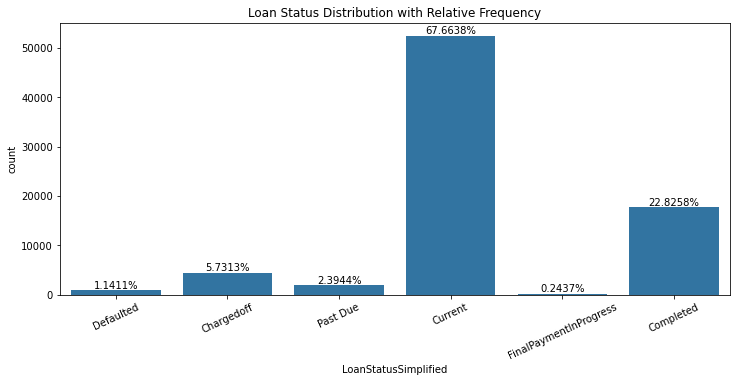

In [41]:
# take a look at loan status distribution over the data set
countplot_categorical_frequencies(loans_except_cancelled, 'LoanStatusSimplified', [12,5],
                                  'Loan Status Distribution with Relative Frequency', 25)

> As we can see, more than half of the loans are current and proportion of loans that are past due, charged off or past due is quite large (~ 14%). Thus, it would be interesting to see what variables could predict the loan outcome. 

This suggests that Prosper rating and scoring systems are working rather well for making decision on a loan and predict defaults.

#### Income Range Distribution

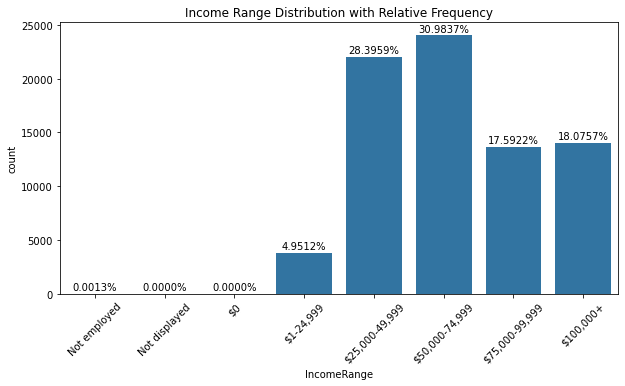

In [42]:
# take a quick glance at income range distribution
# this variable could be a yearly estimate as it contradicts monthly stated income
countplot_categorical_frequencies(loans_except_cancelled, 'IncomeRange', [10,5],
                                  'Income Range Distribution with Relative Frequency', 45)

> This plot demonstrates that most of the loans have income range greater than \$25,000, and only a very small proportion of loans would not have income.

#### Loan Category Distribution

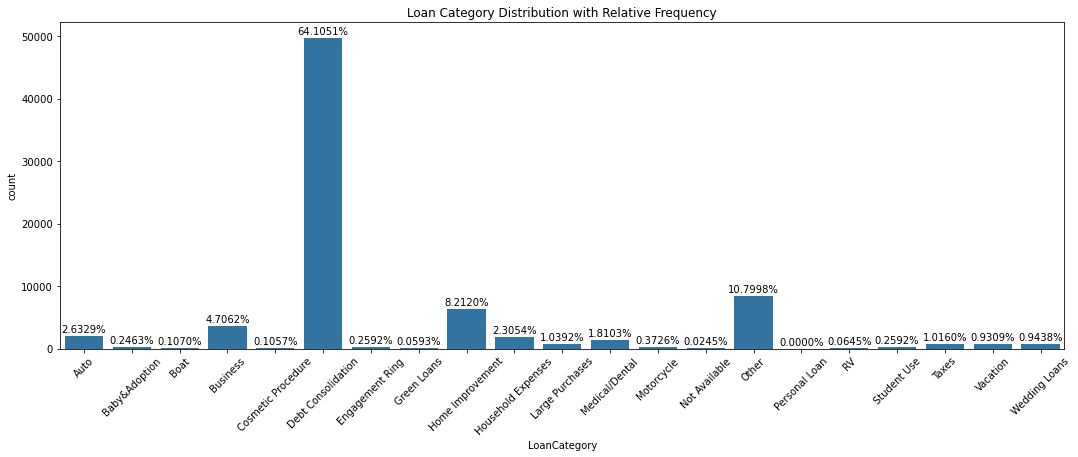

In [43]:
# plot how loans are didtributed across categories
countplot_categorical_frequencies(loans_except_cancelled, 'LoanCategory', [18,6],
                                  'Loan Category Distribution with Relative Frequency', 45)

> Significant portion (circa 56%) of loans are debt consolidation, then home improvement (~7%), while there is a large proportion (circa 19%) for no clear category which has value as 'Not Available' or 'Other'.

> This indicates some client on-boarding and data quality issues, as loan category is potentially one of the indicators driving loan outcome.


#### Occupation Distribution

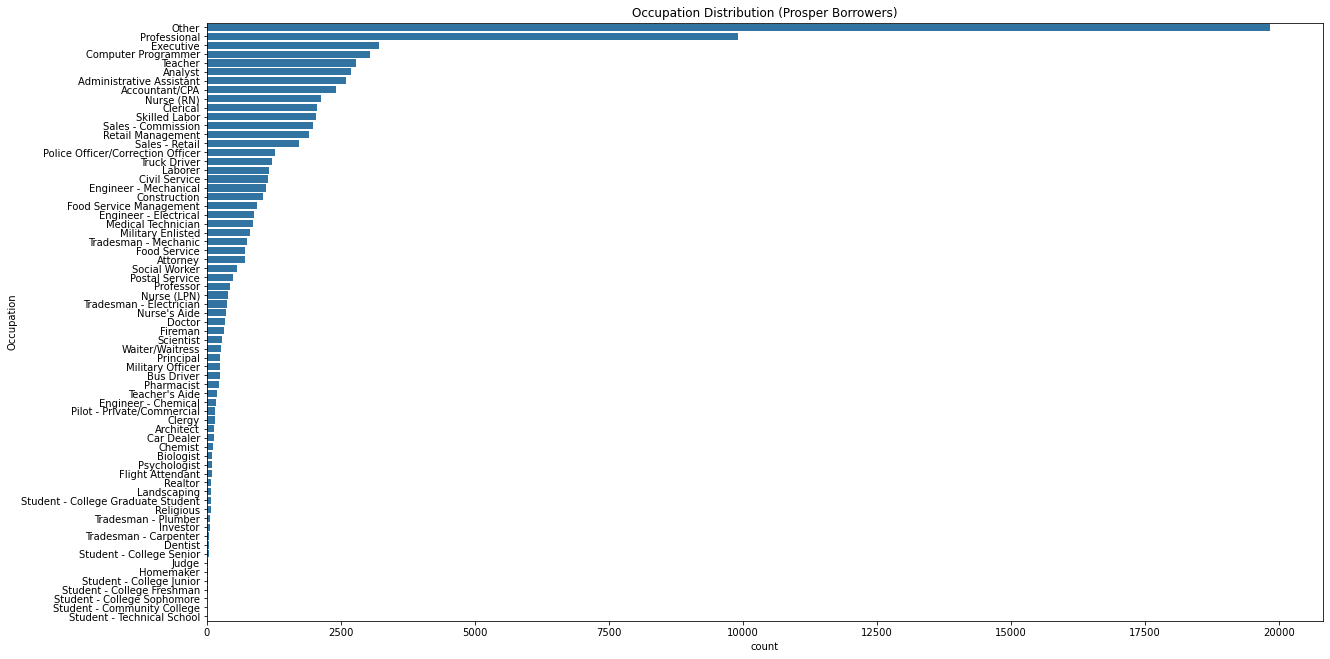

In [44]:
occupation_counts = loans_except_cancelled['Occupation'].value_counts()
occupation_order = occupation_counts.index
fig, ax = plt.subplots(figsize = [20,11])

default_color = sb.color_palette()[0]
sb.countplot(data = loans_except_cancelled, y = 'Occupation', color = default_color, order=occupation_order, ax = ax);
plt.title('Occupation Distribution (Prosper Borrowers)');
#plt.xticks(rotation=65);

> Too many 'Other' values for `Occupation` variable so taking it to the account would produce not very reliable result. 

#### Borrower State Distribution

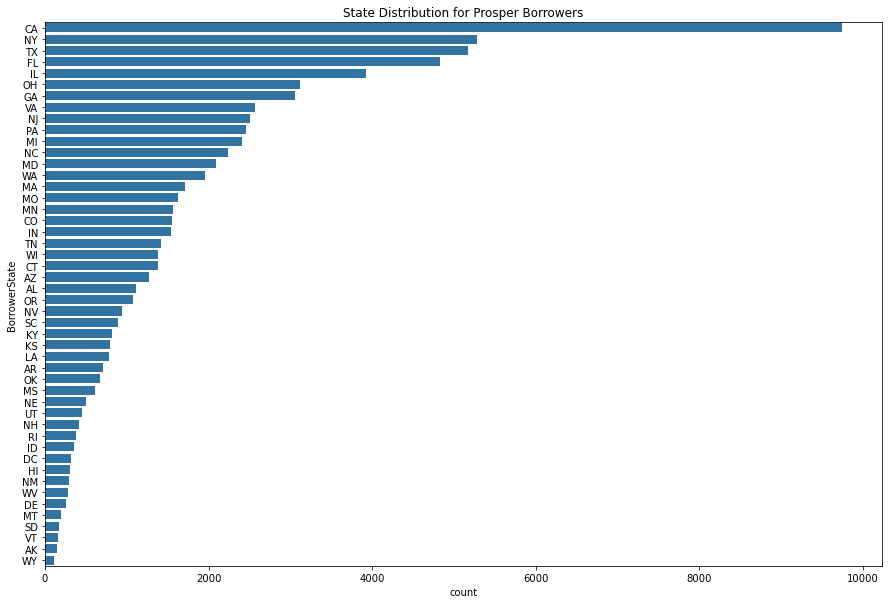

In [45]:
state_counts = loans_except_cancelled['BorrowerState'].value_counts()
state_order = state_counts.index

fig, ax = plt.subplots(figsize = [15,10])

default_color = sb.color_palette()[0]
sb.countplot(data = loans_except_cancelled, y = 'BorrowerState', color = default_color, order=state_order, ax = ax);
plt.title('State Distribution for Prosper Borrowers');
#plt.xticks(rotation=15);

> We can see that loans are not equally distributed across the state. It will be interesting to investigate in bi-variate exploration if some states have bigger proportion of defaulting loans than others

#### Plotting Other Categorical Variables

* IncomeVerifiable
* EmploymentStatus
* IsBorrowerHomeowner
* TermYears
* ProsperRating (Alpha)
* ProsperScore (will be used as categorical variable for most vizualisations)

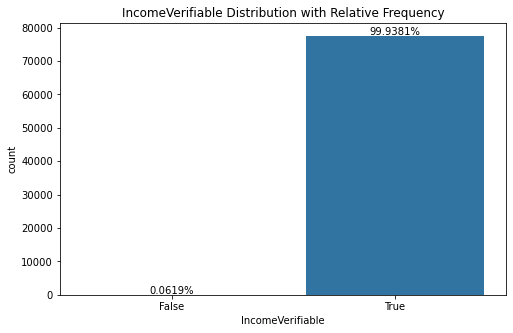

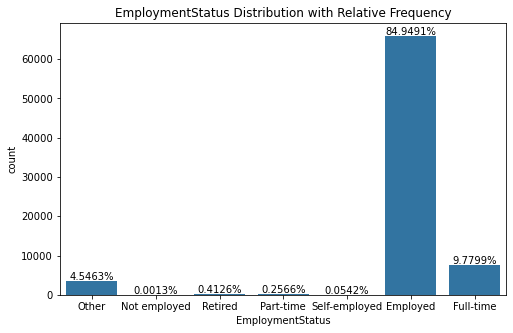

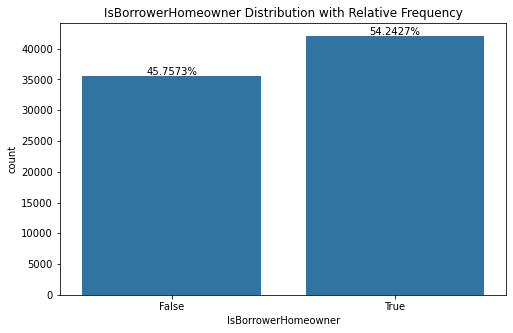

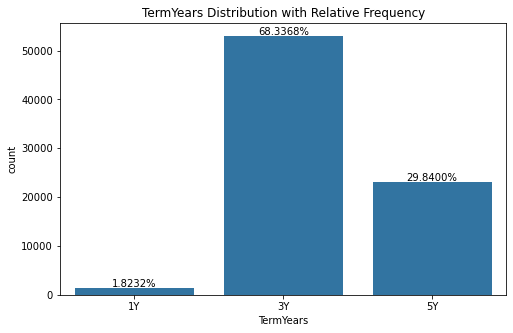

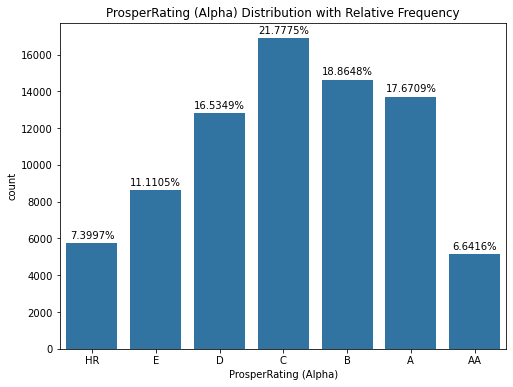

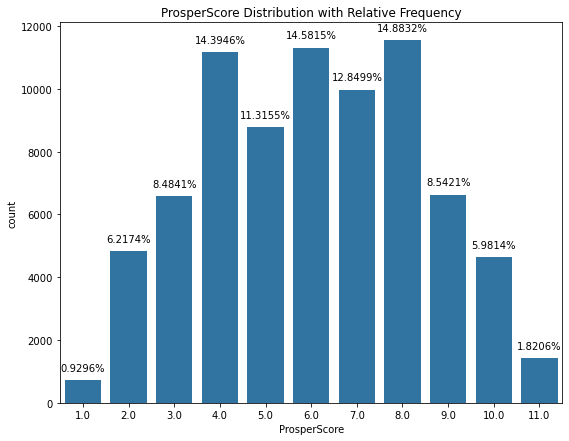

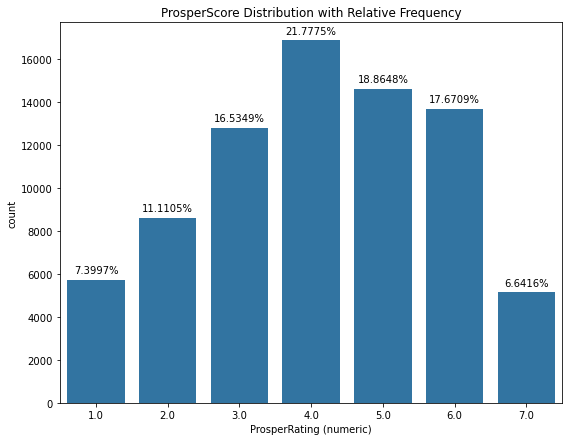

In [46]:
countplot_categorical_frequencies(loans_except_cancelled, 'IncomeVerifiable', [8,5],
                                  'IncomeVerifiable Distribution with Relative Frequency', 0)

countplot_categorical_frequencies(loans_except_cancelled, 'EmploymentStatus', [8,5],
                                  'EmploymentStatus Distribution with Relative Frequency', 0)

countplot_categorical_frequencies(loans_except_cancelled, 'IsBorrowerHomeowner', [8,5],
                                  'IsBorrowerHomeowner Distribution with Relative Frequency', 0)

countplot_categorical_frequencies(loans_except_cancelled, 'TermYears', [8,5],
                                  'TermYears Distribution with Relative Frequency', 0)

countplot_categorical_frequencies(loans_except_cancelled, 'ProsperRating (Alpha)', [8,6],
                                  'ProsperRating (Alpha) Distribution with Relative Frequency', 0)

countplot_categorical_frequencies(loans_except_cancelled, 'ProsperScore', [9,7],
                                  'ProsperScore Distribution with Relative Frequency', 0)

countplot_categorical_frequencies(loans_except_cancelled, 'ProsperRating (numeric)', [9,7],
                                  'ProsperScore Distribution with Relative Frequency', 0)


> As we can see:
* vast majority of Prosper borrowers are employed, and their income is verifiable.
* It looks like being a home owner is not a major factor for making a lending decision as almost 46% of the borrowers are not home owners
* vast majority of loans have term greater than 1Y
* Loan rating distribution follows normal distribution curve peaking at C rating
* ProsperScore distribution looks like a bimodal distribution with peaks at 4.0 and 8.0 score 
* ProsperRating (numeric) distribution looks like a normal distribution with a peak at 4

### Univariate Exploration of Numeric Variables

Now we will plot distribution of other categorical variables in the data set.

#### Bank Card Utilization, Delinquencies, and Borrower Rate
* BankcardUtilization
* DelinquenciesLast7Years
* BorrowerRate


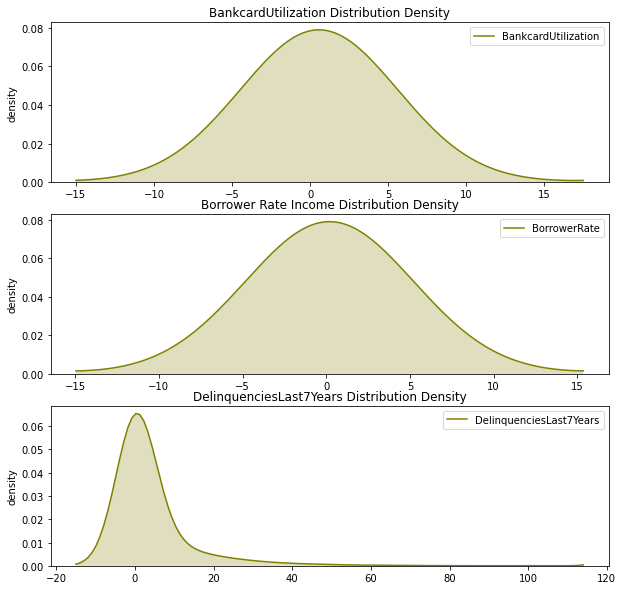

In [47]:
# Plot Bank Card Utilization, BorrowerRate, DelinquenciesLast7Years, Distributions
# Set a larger figure size for subplots
plt.figure(figsize = [10, 10]) 

# 1 row, 2 cols, subplot 1
plt.subplot(3, 1, 1)
sb.kdeplot(loans_except_cancelled['BankcardUtilization'],  shade=True, bw=5, color="olive");
plt.ylabel('density')
plt.title('BankcardUtilization Distribution Density')

plt.subplot(3, 1, 3) # 1 row, 2 cols, subplot 2
sb.kdeplot(loans_except_cancelled['DelinquenciesLast7Years'], shade=True, bw=5, color="olive");
plt.ylabel('density')
plt.title('DelinquenciesLast7Years Distribution Density');

plt.subplot(3, 1, 2)
sb.kdeplot(loans_except_cancelled['BorrowerRate'], shade=True, bw=5, color="olive");
plt.ylabel('density')
plt.title('Borrower Rate Income Distribution Density');


> BorrowerRate and BankCardUtilization show density curve of a bell shape which suggests these variables are normally distributed

> DelinquenciesLast7Years however is largely skewed to the right which would be expected from a lender not to give loans to borrowers who had many delinquencies in the past.

#### Stated Monthly Income Distribution

This variable is suspected to be one of the major factors influencing a loan outcome.
Firstly, let's have a look at the KDE chart for this variable.

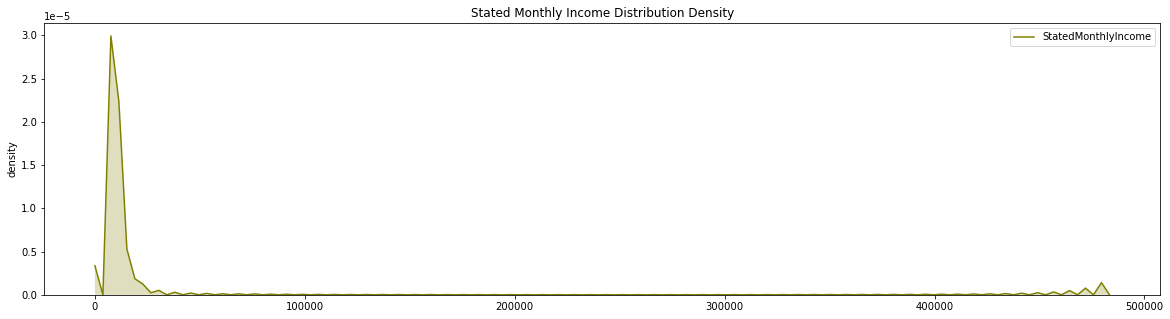

In [48]:
# Plot Monthly Income KDE chart
# Set a larger figure size for subplots
plt.figure(figsize = [20, 5]) 

plt.subplot(1, 1, 1)
sb.kdeplot(loans_cleared['StatedMonthlyIncome'], shade=True, bw=5, color="olive");
plt.ylabel('density')
plt.title('Stated Monthly Income Distribution Density');

Stated monthly income is highly skewed to the right, and it's looks like there are outliers around 400,000+ mark.

It will be useful to have a look at the descriptive statistics for this variable.

In [49]:
loans_except_cancelled['StatedMonthlyIncome'].describe()

count     77557.000000
mean       5963.503215
std        5082.144391
min           0.250000
25%        3533.333333
50%        5000.000000
75%        7166.666667
max      483333.333333
Name: StatedMonthlyIncome, dtype: float64

Interestingly max value looks like a very odd outlier as it is far greater than median.
Let's have a closer look at the outliers where stated monthly income is greater than \$100,000.

In [50]:
# select high outliers, using criteria eyeballed from the plots

high_outliers = ((loans_except_cancelled['StatedMonthlyIncome'] > 100000) 
                 | (loans_except_cancelled['StatedMonthlyIncome'] == 0))
print(high_outliers.sum())
print(loans_except_cancelled.loc[high_outliers,:])

6
        log_loan_amt TermYears LoanStatusSimplified  BorrowerRate  \
8066        3.301030        3Y            Completed        0.3199   
17411       3.875061        3Y            Completed        0.3199   
57133       3.602060        3Y              Current        0.3199   
80075       4.397940        3Y              Current        0.1655   
111265      4.106021        5Y            Completed        0.1819   
113270      3.301030        3Y              Current        0.1899   

        ProsperRating (numeric)  ProsperScore ProsperRating (Alpha)  \
8066                        1.0           4.0                    HR   
17411                       2.0           5.0                     E   
57133                       2.0           5.0                     E   
80075                       4.0           6.0                     C   
111265                      5.0           9.0                     B   
113270                      4.0           6.0                     C   

              Lo

Those outliers look like a data quality issue and likely were typed into the system incorrectly. Interestingly a police officer had stated monthly salary higher than an executive!

Next let's look at the stated monthly income on a histogram without any scale transformations:

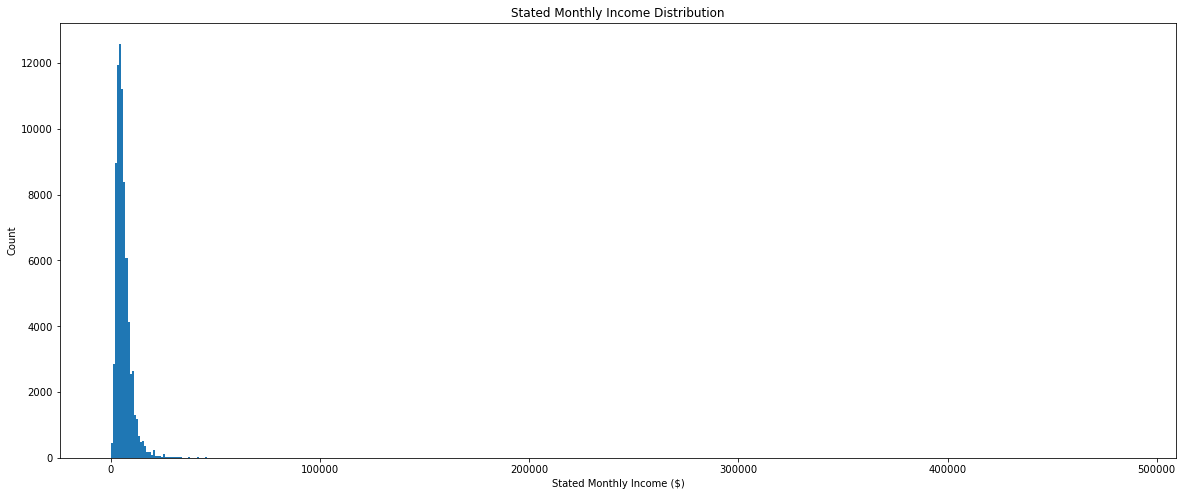

In [51]:
# have a look at the hostogram for stated monthly income 
# start with a standard-scaled plot
binsize = 1000
bins = np.arange(0, 485000 +binsize, binsize)

plt.figure(figsize=[20, 8])
plt.hist(data = loans_except_cancelled, x = 'StatedMonthlyIncome', bins = bins)
plt.xlabel('Stated Monthly Income ($)')
plt.ylabel('Count')
plt.title('Stated Monthly Income Distribution')
#plt.xlim([0, 500000])
plt.show()

It is really hard to see the distribution because of the outliers and skewness.
Let's try to apply log scale on stated monthly income:

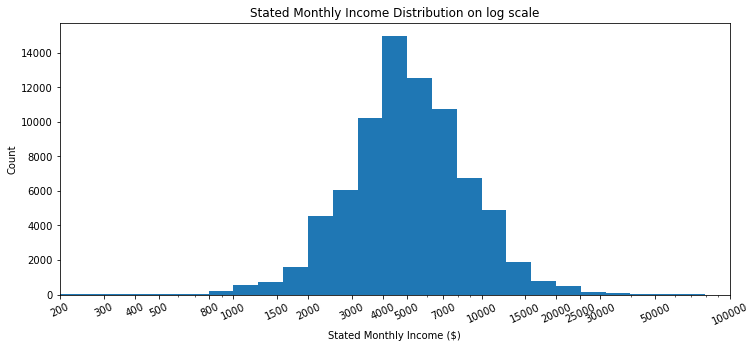

In [52]:
# zoom in on monthly stated income
binsize = 5000
bins = 10 ** np.arange(-1, 6 + 0.1, 0.1)

plt.figure(figsize=[12, 5])

# Generate the x-ticks you want to apply
ticks = [100, 200, 300, 400, 500, 800, 1000, 1500, 2000, 3000, 4000, 
         5000, 7000, 10000, 15000, 20000, 25000, 30000, 50000, 100000]
# Convert ticks into string values, to be displaye dlong the x-axis
labels = ['{}'.format(v) for v in ticks]

plt.hist(data = loans_except_cancelled, x = 'StatedMonthlyIncome', bins = bins)
plt.xscale('log')
plt.xlabel('Stated Monthly Income ($)')
plt.ylabel('Count')
# Apply x-ticks
plt.xticks(ticks, labels, rotation=25)
plt.xlim([200, 100000])
plt.title('Stated Monthly Income Distribution on log scale')
plt.show();

Now we can see that stated monthly income distribution is lognormal.

#### Debt to Income Ratio Distribution

Next, debt-to-income ratio will be investigated, starting with KDE and violin plot to eyeball this variable kernel density distribution.

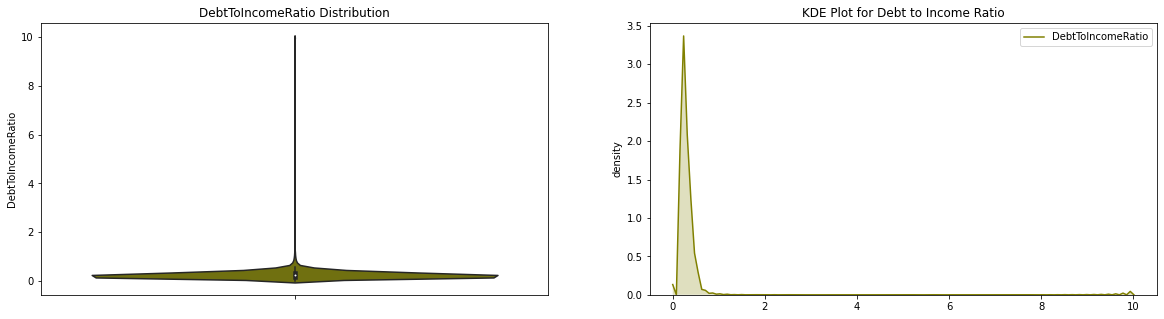

In [53]:
# plot DebtToIncomeRatio Distribution - KDE and vilolin plot side by side
plt.figure(figsize = [20, 5])

plt.subplot(1, 2, 1)
ax = sb.violinplot(y=loans_except_cancelled['DebtToIncomeRatio'], showfliers = True, color="olive")
plt.title('DebtToIncomeRatio Distribution');

plt.subplot(1, 2, 2) # 1 row, 2 cols, subplot 2
sb.kdeplot(loans_except_cancelled['DebtToIncomeRatio'], shade=True, bw=0.0005, color="olive");
plt.ylabel('density')
plt.title('KDE Plot for Debt to Income Ratio');

We can see similar problem as with stated monthly income : the variable is highly skewed to the right and there are outliers at the end of the right tail.

Let's have a look at the descriptive statistics for this variable:

In [54]:
loans_except_cancelled['DebtToIncomeRatio'].describe()

count    77557.000000
mean         0.258752
std          0.318326
min          0.000000
25%          0.150000
50%          0.220000
75%          0.320000
max         10.010000
Name: DebtToIncomeRatio, dtype: float64

Let's print the outliers for debt-to-income ratio:

In [55]:
# select high outliers, using criteria eyeballed from the plots

high_outliers = ((loans_except_cancelled['DebtToIncomeRatio'] > 10))
print(high_outliers.sum())
print(loans_except_cancelled.loc[high_outliers,:])

46
        log_loan_amt TermYears LoanStatusSimplified  BorrowerRate  \
626         3.301030        3Y              Current        0.3177   
2155        4.130334        3Y            Completed        0.0930   
5806        3.301030        3Y            Completed        0.3177   
7871        3.602060        3Y              Current        0.3177   
8748        3.477121        3Y           Chargedoff        0.3220   
10018       3.477121        3Y              Current        0.2859   
10969       3.602060        3Y              Current        0.3134   
12013       4.000000        5Y              Current        0.2870   
14126       4.176091        5Y             Past Due        0.2498   
16849       4.000000        3Y              Current        0.2786   
26112       3.342423        3Y            Completed        0.3199   
27865       3.301030        3Y              Current        0.3177   
30827       3.397940        3Y            Defaulted        0.2958   
34600       3.602060        3Y 

It makes sense to plot debt-to-income variable on the log scale:

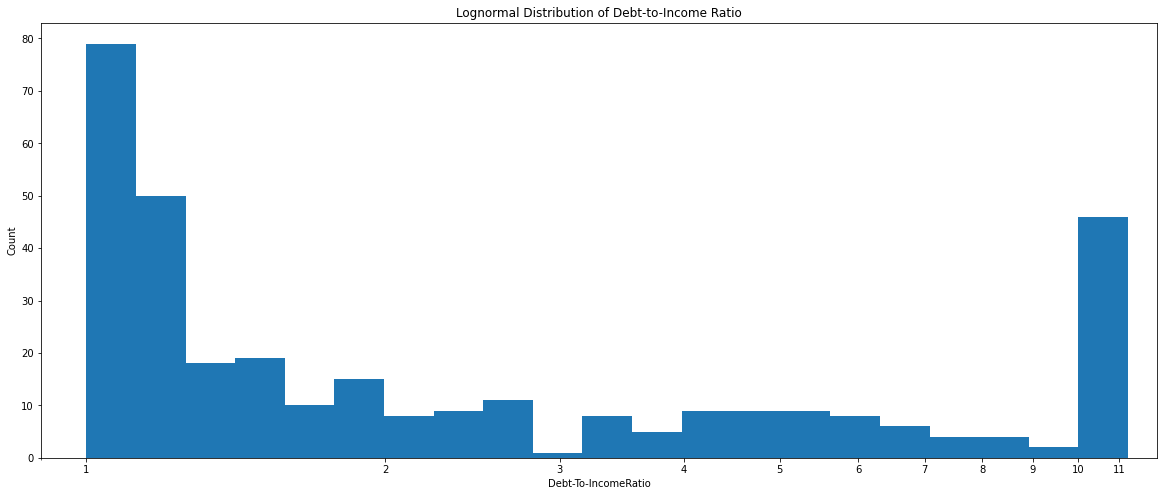

In [56]:
# plot lognormal Distribution of Debt-to-Income Ratio
binsize = 0.05
bins = 10 ** np.arange(0, 10.01 +binsize, binsize)

# Generate the x-ticks you want to apply
ticks = [1,2,3,4,5,6,7,8,9,10,11]
# Convert ticks into string values, to be displaye dlong the x-axis
labels = ['{}'.format(v) for v in ticks]


plt.figure(figsize=[20, 8])
plt.hist(data = loans_except_cancelled, x = 'DebtToIncomeRatio', bins = bins)
plt.xscale('log')
plt.xlabel('Debt-To-IncomeRatio')
plt.xticks(ticks, labels)
plt.xlim([0.9, 12])
plt.ylabel('Count')
plt.title('Lognormal Distribution of Debt-to-Income Ratio')
plt.show()

Debt-to-income ratio log normal distribution still looks highly skewed to the right, with two peaks around 1 and 11 values.
Log scale might not be appropriate for debt-to-income ratio, hence I will not use scale transformations for this variable going forward.

#### Loan Original Amount Distribution

Firstly, let's have a look at the density estimation for the loan original amount:

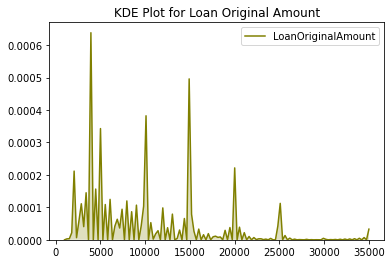

In [57]:
sb.kdeplot(loans_except_cancelled['LoanOriginalAmount'], shade=True, bw=5, color="olive");
plt.title('KDE Plot for Loan Original Amount');

It looks like loan original amount distribution is skewed to the right and multi-modal having peaks at the bars of \$5000 increase. This probably represent that loans have standard amounts based on the information provided by a borrower.

Next, I will plot loan original amount as a histogram: 

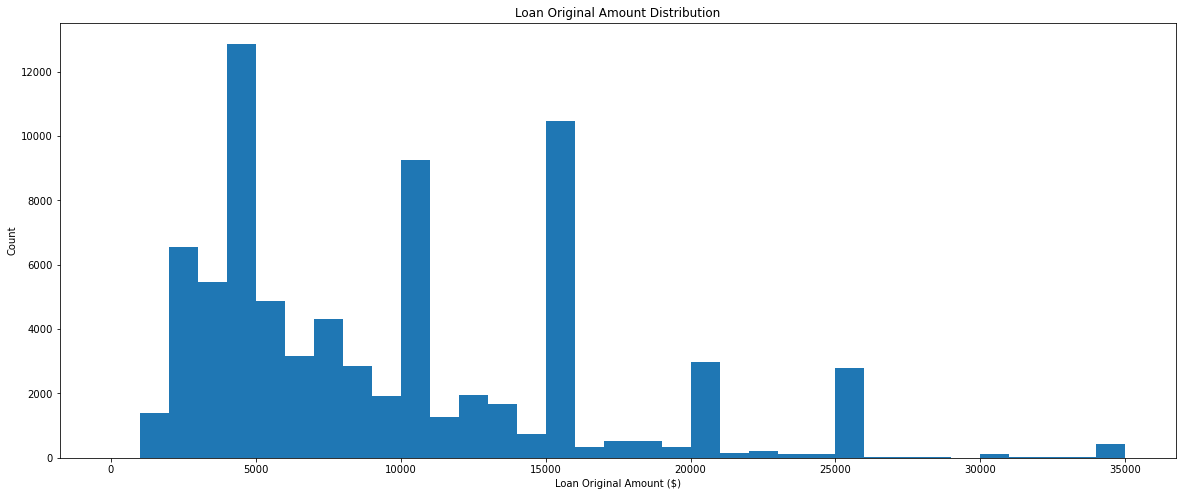

In [58]:
# Histogram for Loan Original Amount
binsize = 1000
bins = np.arange(0, 35000 +binsize, binsize)
plt.figure(figsize=[20, 8])
plt.hist(data = loans_except_cancelled, x = 'LoanOriginalAmount', bins = bins)
plt.xlabel('Loan Original Amount ($)')
#plt.xlim([0, 500000])
plt.ylabel('Count')
plt.title('Loan Original Amount Distribution');
plt.show();

This plot shows similar picture to the KDE plot.
It makes sense to plot loan original amount on log scale as it is skewed to the right.

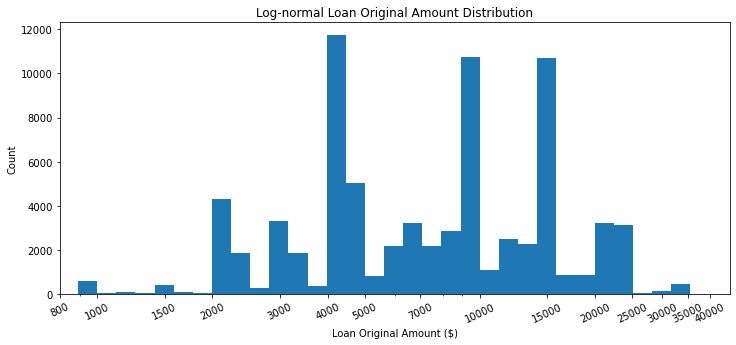

In [59]:
# plot Log-normal Loan Original Amount Distribution
bins = 10 ** np.arange(-1, 6 + 0.05, 0.05)

plt.figure(figsize=[12, 5])

# Generate the x-ticks you want to apply
ticks = [800, 1000, 1500, 2000, 3000, 4000, 
         5000, 7000, 10000, 15000, 20000, 25000, 30000, 35000, 40000]
# Convert ticks into string values, to be displaye dlong the x-axis
labels = ['{}'.format(v) for v in ticks]

plt.hist(data = loans_except_cancelled, x = 'LoanOriginalAmount', bins = bins)
plt.xscale('log')
plt.xlabel('Loan Original Amount ($)')
# Apply x-ticks
plt.xticks(ticks, labels, rotation=25)
plt.xlim([800, 45000])
plt.ylabel('Count')
plt.title('Log-normal Loan Original Amount Distribution');
plt.show();

> As we can see, even log-scaled distribution for loan original amount is multi-modal with noticeable peaks around \\$5,000, \\$10,000, and \$15,000.

### Discuss the distribution(s) of your variable(s) of interest. Were there any unusual points? Did you need to perform any transformations?

> More than half of the loans in the resultant data set is in 'Current' status. The  proportion of loans that are past due, charged off or past due is surprisingly large (~ 14%). 

> 'ProsperScore' and 'ProsperRating (Alpha)' look normally distributed

### Of the features you investigated, were there any unusual distributions? Did you perform any operations on the data to tidy, adjust, or change the form of the data? If so, why did you do this?

> While investigating the dataset after data wrangling in the section 1.3, number of interesting observations were identified:
* Loan Original Amount: The variable took on a large range of values, so I looked at the data using a log transform. It looks like loan amount has standard values increasing by \\$5000 with most common \\$5,000, \\$10,000, and \$15,000
* Stated Monthly Income: The variable took on a large range of values, so I looked at the data using a log transform.This variable had 6 entries where value is greater than \$100,000. This looks like a data quality issue, however I was not able to verify this assumption, and therefore these points were left in the data set.
* Debt-to-income ratio distribution was also plotted using log transform, however there is still a large spike at the right end with 46 entries having value greater than 10.

## Bivariate Exploration

> In this section, I will investigate relationships between pairs of variables in the 
resultant data set after data wrangling was completed. 

> To start with, let's clearly define list for numeric and categorical variables.
> Note: `ProsperScore` and `ProsperRating (numeric)` are arguably categorical variables, however I kept them numeric for investigating their correlation with other numerical variables:


In [60]:
numeric_vars = [
'BorrowerRate',
'StatedMonthlyIncome',
'LoanOriginalAmount',
'DelinquenciesLast7Years',
'BankcardUtilization', 
'DebtToIncomeRatio',
'ProsperRating (numeric)',
'ProsperScore'
]


categoric_vars = [
'LoanCategory'    
'ProsperRating (Alpha)',
'LoanStatus',
'EmploymentStatus',
'BorrowerState',
'Occupation']

### Correlation Among Numerical Variables 

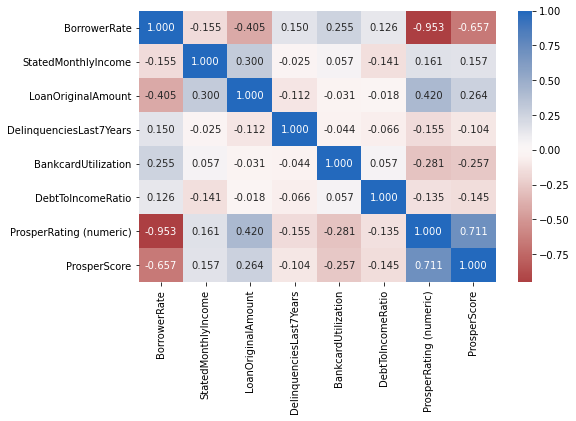

In [61]:
# correlation plot
plt.figure(figsize = [8, 5])
sb.heatmap(loans_except_cancelled[numeric_vars].corr(), annot = True, fmt = '.3f',
           cmap = 'vlag_r', center = 0)
plt.show()

As we can see Borrower Rate is correlated to `Prosper Score`.
Thus I will be investigating only `Borrower Rate` further.

`Prosper Rating (numeric)` is also highly correlated to `Prosper Score` so that prosper score system seems to be consistent for these two variables.

Surprisingly `ProsperScore` does not show strong correlation with these variables:
* `BankCardUtilization`
* `StatedMonthlyIncome`
* `LoanOriginalAmount`
* `DelinquenciesLast7Years`

Nevertheless, `ProsperScore` negatively correlated with `BorrowerRate` as expected: the higher the rating, the lower the rate (as expected).


Interestingly, `StatedMonthlyIncome` does not have strong correlation with `DebtToIncomeRatio`.

### Categorical Variables vs Loan Status

Now we will plot categorical variables distribution over loan status (`LoanStatusSimplified`) for:
* ProsperRating (Alpha)
* ProsperScore
* Loan Category
* Occupation
* Borrower State
* EmploymentStatus

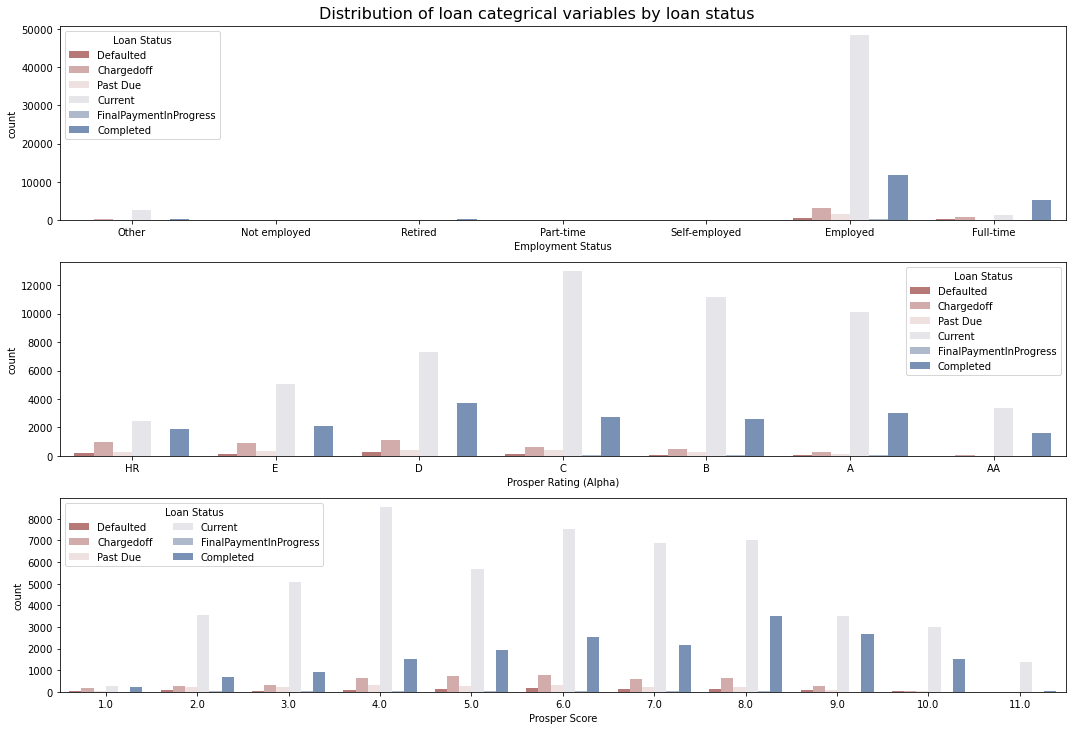

In [62]:
# plot for Employment Status, Prosper Score and Prosper Rating 
#categorical variables vs LoanStatusSimplified
fig, ax = plt.subplots(nrows=3, figsize = [15,10])
fig.suptitle('Distribution of loan categrical variables by loan status', y=1.01, fontsize=16)
default_color = sb.color_palette()[0]

#sb.countplot(data = loans_except_cancelled, x = 'IncomeVerifiable', palette = 'vlag_r', ax = ax[0], hue= 'LoanStatusSimplified')
#sb.countplot(data = loans_except_cancelled, x = 'IsBorrowerHomeowner', palette = 'vlag_r', ax = ax[2], hue= 'LoanStatusSimplified')
#sb.countplot(data = loans_except_cancelled, x = 'TermYears', palette = 'vlag_r', ax = ax[3], hue= 'LoanStatusSimplified')
sb.countplot(data = loans_except_cancelled, x = 'EmploymentStatus', 
             palette = 'vlag_r', ax = ax[0], hue= 'LoanStatusSimplified')
ax[0].legend(loc = 'upper left', ncol = 1, title = 'Loan Status')
ax[0].set_xlabel('Employment Status')

sb.countplot(data = loans_except_cancelled, x = 'ProsperRating (Alpha)',
             palette = 'vlag_r', ax = ax[1], hue= 'LoanStatusSimplified')
ax[1].legend(loc = 'upper right', ncol = 1, title = 'Loan Status')
ax[1].set_xlabel('Prosper Rating (Alpha)')

sb.countplot(data = loans_except_cancelled, x = 'ProsperScore', 
             palette = 'vlag_r', ax = ax[2], hue= 'LoanStatusSimplified')
ax[2].legend(loc = 'upper left', ncol = 2, title = 'Loan Status')
ax[2].set_xlabel('Prosper Score')

plt.tight_layout()
plt.show();

Next I will plot occupation distribution among loan outcomes:

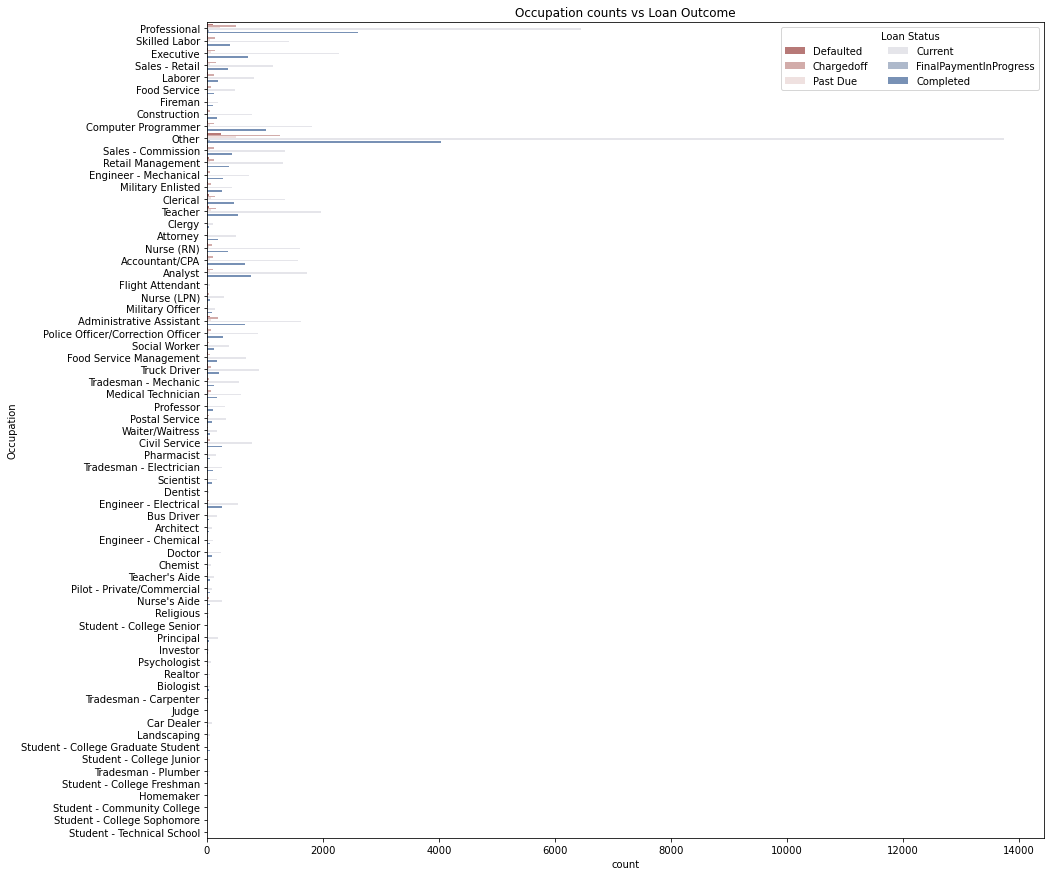

In [63]:
# countplot for occupation vs loan outcome
fig, ax = plt.subplots(figsize = [15,15])

default_color = sb.color_palette()[0]
sb.countplot(data = loans_except_cancelled, y = 'Occupation', 
             hue='LoanStatusSimplified', palette='vlag_r', ax = ax);
plt.legend(loc = 'upper right', ncol = 2, title = 'Loan Status')
plt.title('Occupation counts vs Loan Outcome');

> This plot shows that some occupations outperform others. For example, professionals, executives, teachers, accountants, analysts look as more reliable occupations for taking a loan than others.
> This could be related to the nature of the job (seasonal/contractual vs permanent or government subsidized).

Next, let's explore 'BorrowerState' counts vs 'LoanStatusSimplified'

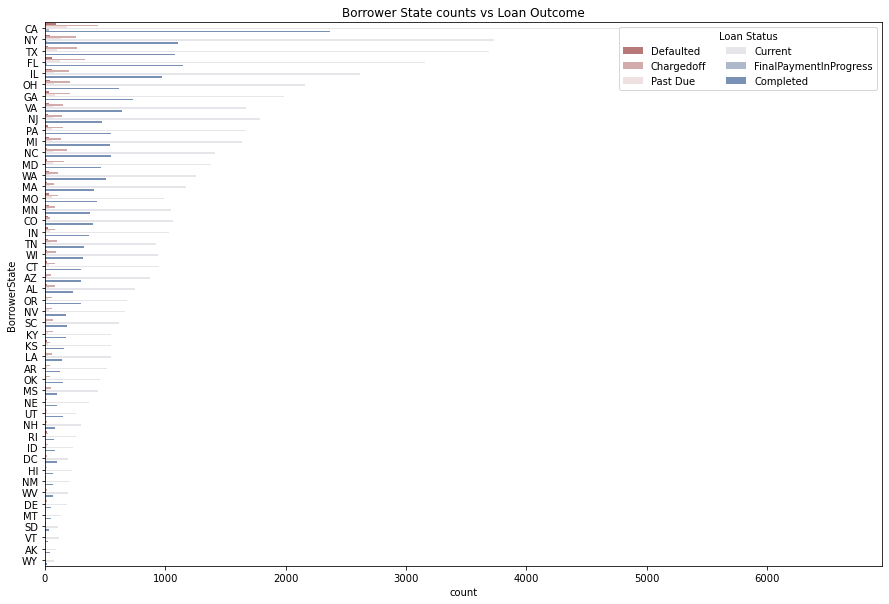

In [64]:
fig, ax = plt.subplots(figsize = [15,10])

default_color = sb.color_palette()[0]
sb.countplot(data = loans_except_cancelled, 
             y = 'BorrowerState', hue='LoanStatusSimplified', 
             palette='vlag_r', ax = ax, order=state_order);
plt.legend(loc = 'upper right', ncol = 2, title = 'Loan Status')
plt.title('Borrower State counts vs Loan Outcome');

This plot shows that some states outperform other states. For example, California has the largest proportion of loans, but it is possible to estimate by the plot that proportion of defaulted/charged-off/past due loans for this state is smaller than for other states.

Now let's plot one of the most interesting factors, LoanCategory vs loan status

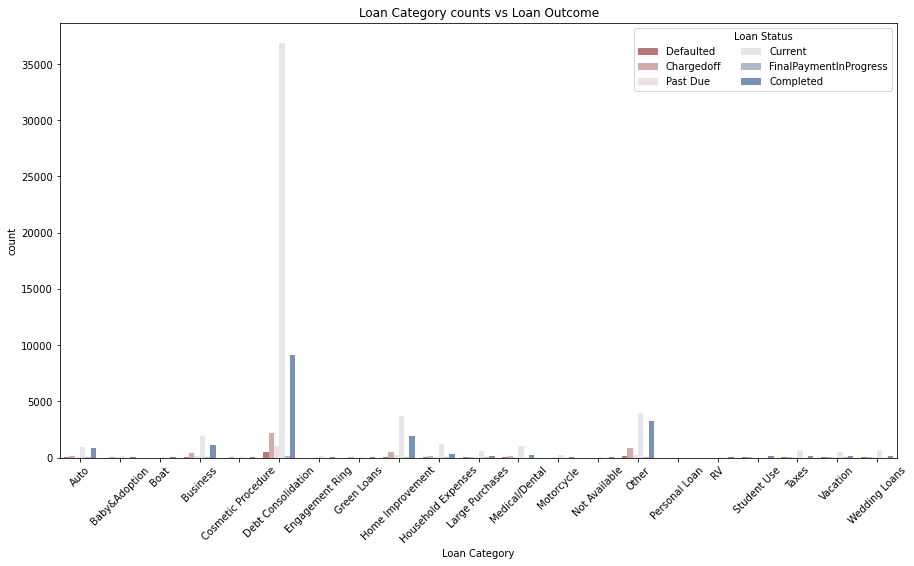

In [65]:
plt.figure(figsize = [15, 8])
ax = plt.subplot(1, 1, 1)
sb.countplot(data = loans_except_cancelled, hue = 'LoanStatusSimplified',
             x = 'LoanCategory', palette = 'vlag_r')
plt.legend(loc = 'upper right', ncol = 2, title = 'Loan Status') # re-arrange legend to remove overlapping
plt.xlabel('Loan Category')
plt.title('Loan Category counts vs Loan Outcome');
plt.xticks(rotation=45);

This plot is not very easy to read because of debt consolidation loans dominance. Let's try to create a heat map with loan count for each category instead.

In [66]:
# remove categories where loan count is 0:
loans_except_cancelled.LoanCategory.cat.remove_unused_categories(inplace=True)
# create counts for each loan category
category_counts = loans_except_cancelled.groupby(['LoanCategory']).LoanStatusSimplified.value_counts().sort_index()
category_counts = category_counts.unstack()
category_counts.fillna(value=0, inplace=True)


In [67]:
# rearrange the column list for counts dataframe
loan_categories_lst = ['Defaulted', 'Chargedoff','Past Due',
                       'Current', 'FinalPaymentInProgress','Completed']
category_counts = category_counts[loan_categories_lst]

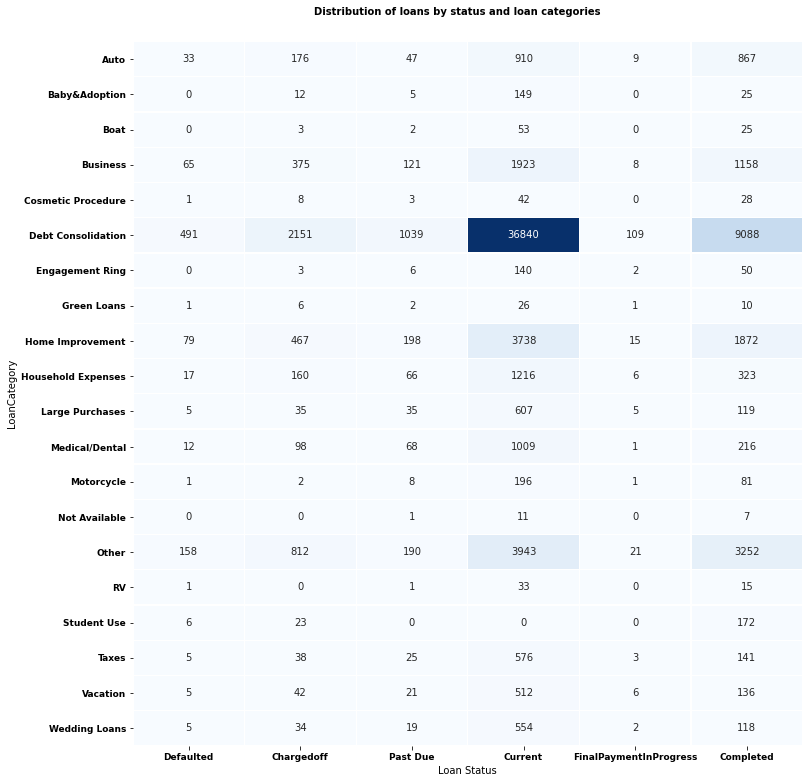

In [68]:
# Drawing a heatmap with the numeric values in each cell
fig4, ax = plt.subplots(figsize=(12, 12))
fig4.subplots_adjust(top=.94)
plt.suptitle('Distribution of loans by status and loan categories', fontsize=10, fontweight='bold')

ax.set_yticklabels(ax.get_yticklabels(), ha="right", fontsize=9, weight='bold')
ax.set_xticklabels(ax.get_xticklabels(), fontsize=9, weight='bold')

#cbar_kws = {'orientation':"horizontal", 'pad':0.05, 'aspect':50}
g = sb.heatmap(category_counts, annot=True, fmt='.0f',
               linewidths=.3, ax=ax, cmap='Blues', cbar=False);
plt.xlabel('Loan Status');

Using both the heat-map and count plot for the loan category we can see it is relevant to the outcome of the loan. In particular, category 'Debt Consolidation' has the most loan allocation including defaulted, charged off, past due loans. 

### Plotting Numerical Features vs Categorical Features

Now it will be interesting to see interactions between categorical and numerical variables in the data set.

Let's start with pair-wise charts for numerical variables versus following categorical variables:
* 'ProsperRating (Alpha)'
* 'LoanStatusSimplified'
* 'EmploymentStatus'

Note: as loan category has a wide range of values it would be extremely hard to interpret facet grid plot including this variable.

Note: Prosper Score is used as numerical variable in this plot.

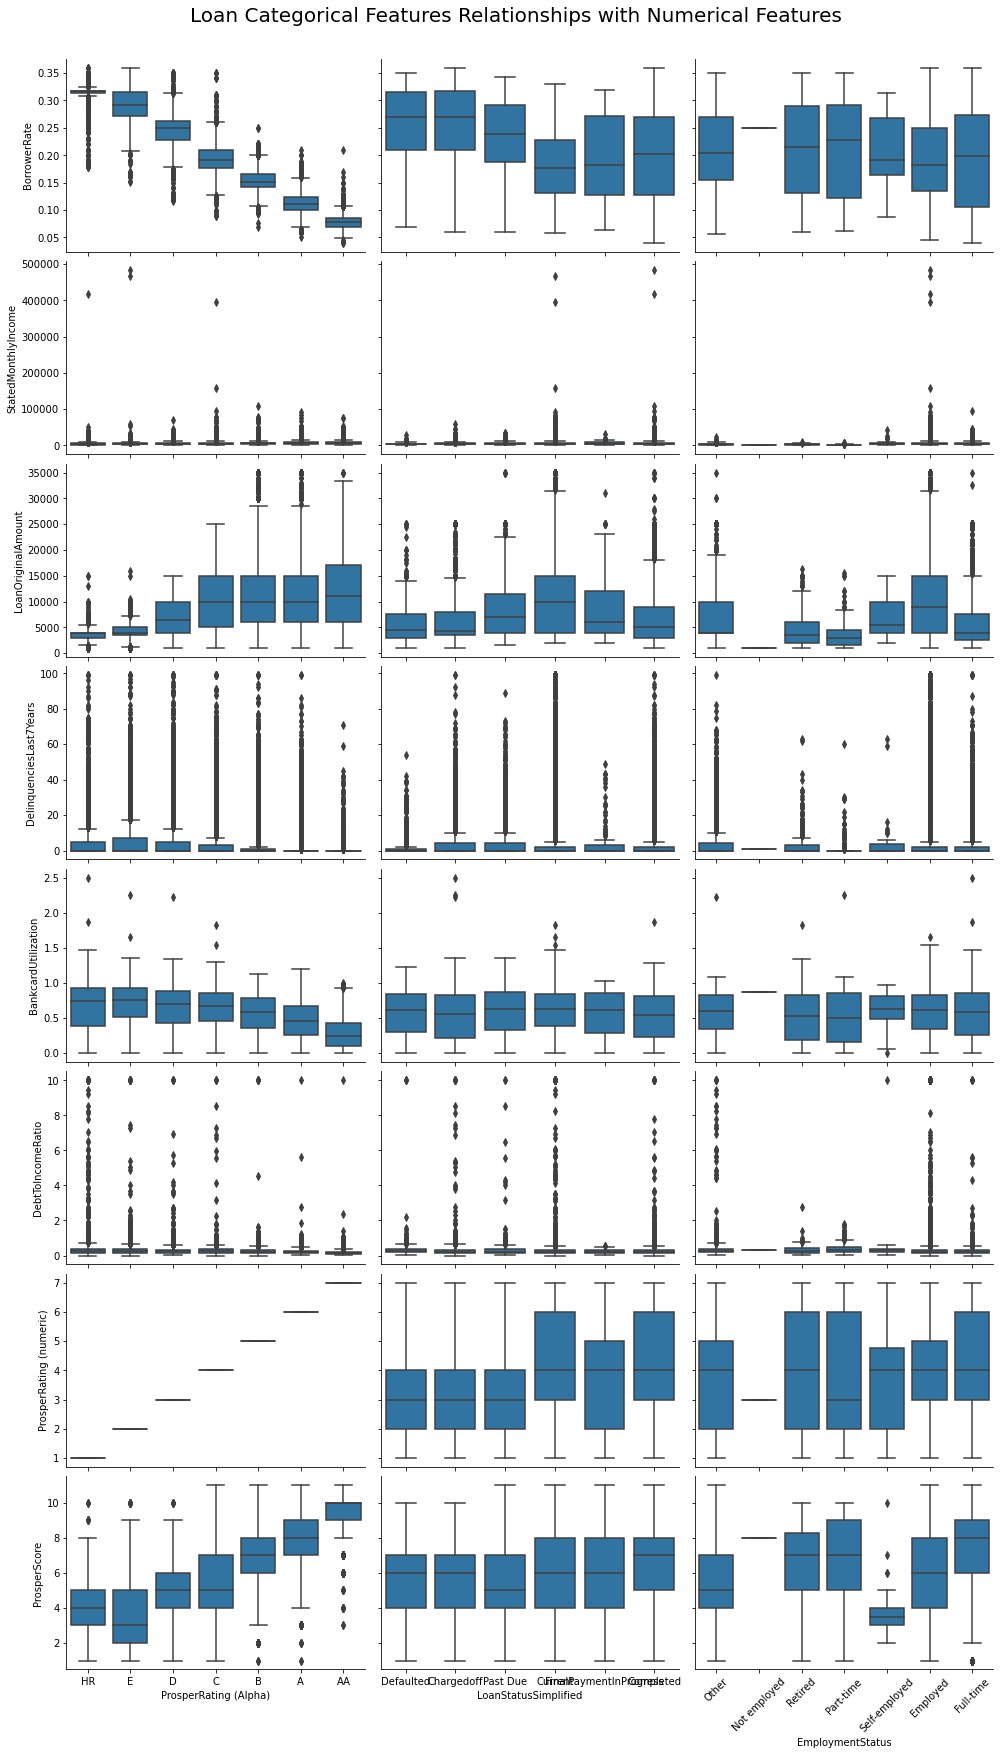

In [69]:
# plot matrix of numeric features against categorical features.
# can use a larger sample since there are fewer plots and they're simpler in nature.


loans_samp = loans_except_cancelled.sample(n=5000, replace=False)

def boxgrid(x, y, **kwargs):
    """ Quick hack for creating box plots with seaborn's PairGrid. """
    default_color = sb.color_palette()[0]
    sb.boxplot(x, y, color = default_color)

#plt.figure(figsize = [20, 20])


g = sb.PairGrid(data = loans_except_cancelled, y_vars = numeric_vars,
                x_vars = ['ProsperRating (Alpha)' , #'TermYears',
                          'LoanStatusSimplified','EmploymentStatus'],
                height = 3, aspect = 1.5);
g.map(boxgrid);
g.fig.subplots_adjust(top=0.95)
g.fig.suptitle('Loan Categorical Features Relationships with Numerical Features',
              fontsize=20);
plt.xticks(rotation=45)
plt.show();

Noticeable correlations:
* Prosper Rating (alpha):
    * negatively correlated with Borrower Rate (as expected)
    * Prosper Rating (numeric) - strongly correlated; even looks as direct mapping matching  description for the column
    * ProsperScore : overall there is a strong positive correlation, however there are outliers for ProsperRating (Alpha) with higher values 'B', 'A', 'AA'. Thus, ProsperScore could be a more sophisticated indicator than Loan Rating 
    * There is a negative correlation with `DelinquenciesLast7Years` as would expected, however it would be interesting to explore this relationship further.
    * `LoanOriginalAmount` is positively correlated to loan rating

* `ProsperScore`:
    * `EmploymentStatus` correlates with `ProsperScore`. Interestingly `ProsperScore` on average is higher for Retired and Part-Time than compared to `Employed` borrowers. This indicates that `Employed` is over-generalised value and shall be more granular to understand type of employment. As expected, borrowers with 'Full Time' EmploymentStatus have higher `ProsperScore` on average. However, borrowers employed part-time have lower Prosper Rating. Values 'Other' and 'Employed' also make difficult to see clear relationship with `LoanOriginalAmount` but it looks like people who are employed tend to get higher loan amount. 
    * `LoanStatusSimplified` - the box plot does not provide much evidence that `ProsperScore` can influence loan outcome, however it would be interesting to explore this relationship further in conjunction with other variables such as `LoanOriginalAmount`, `BorrowerRate`, `EmploymentStatus`

* `LoanStatusSimplified`
    * It seems that `BankCardUtilization` and `EmploymentStatus` are not highly correlated to the loan outcome in pairwise relationships. 
    
* `StatedMonthlyIncome`
This pair-grid box plot is unreadable for this variable so we will investigate its relationships with other variables separately.

Next I will explore debt-to-income relationship with loan status and Prosper Score as two bivariate plots.
Note: whiskers were hidden to make the plot clearer.

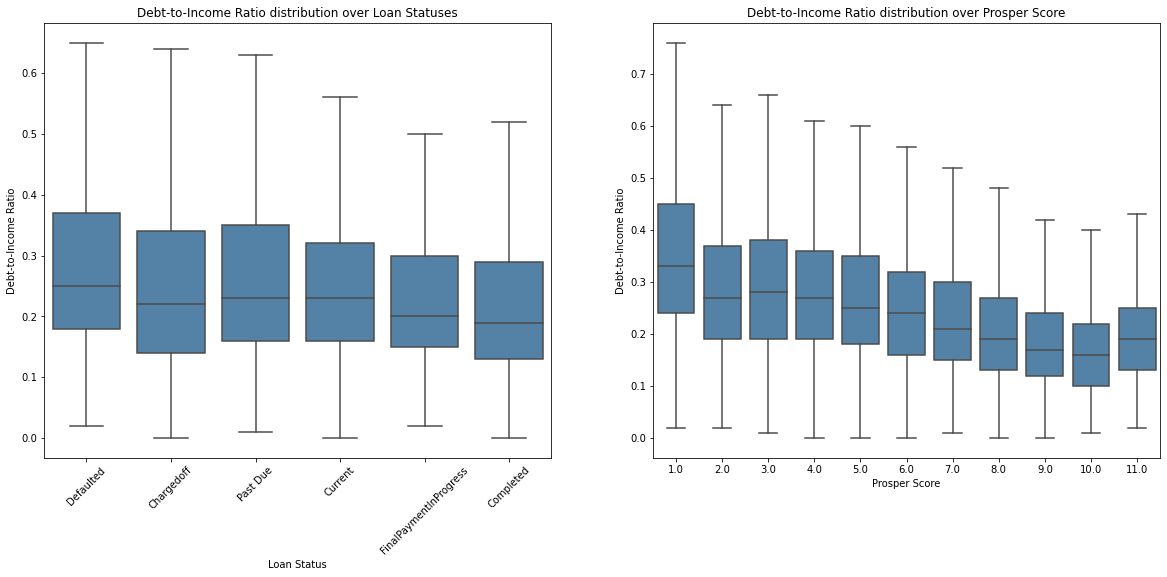

In [70]:
# Debt-to-income distribution in relation to loan outcome and Prosper Rating
plt.figure(figsize = [20, 8])

plt.subplot(1, 2, 1)
sb.boxplot(data=loans_except_cancelled, x='LoanStatusSimplified',
           y='DebtToIncomeRatio', color='steelblue', showfliers=False);
plt.ylabel('Debt-to-Income Ratio')
plt.xlabel('Loan Status')
#plt.yscale('log');
plt.xticks(rotation=45);
plt.title('Debt-to-Income Ratio distribution over Loan Statuses');

plt.subplot(1, 2, 2)
sb.boxplot(data=loans_except_cancelled, x='ProsperScore',
           y='DebtToIncomeRatio', color='steelblue', showfliers=False);
plt.ylabel('Debt-to-Income Ratio')
plt.xlabel('Prosper Score')
#plt.yscale('log');
plt.title('Debt-to-Income Ratio distribution over Prosper Score');

Now we will have a look at `DelinquenciesLast7Years` relationship with loan status and Prosper Score as two bivariate plots:

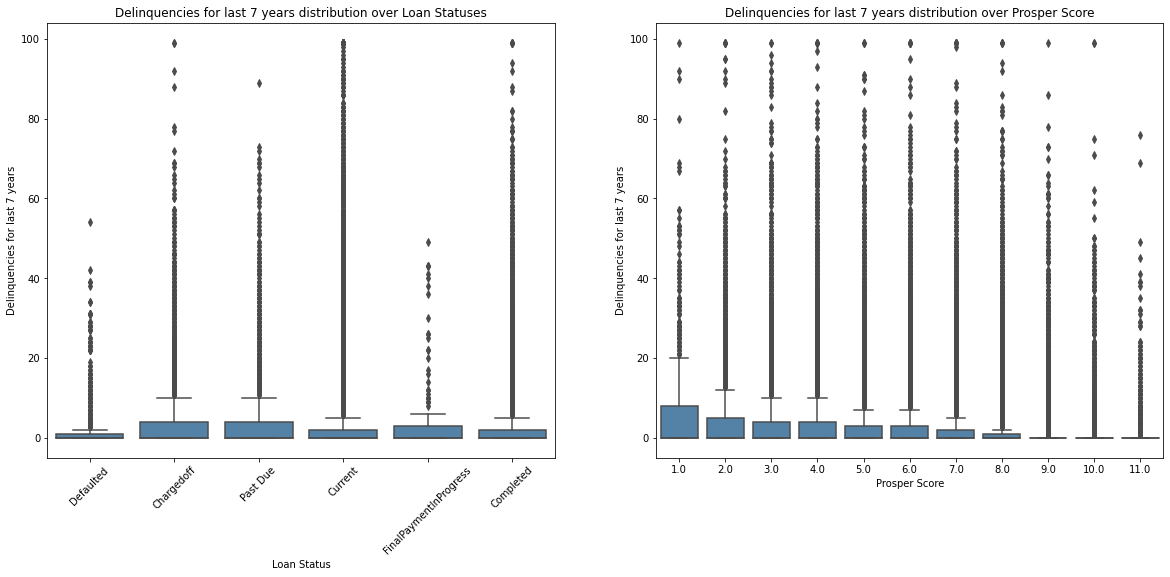

In [71]:
# DelinquenciesLast7Years distribution in relation to loan outcome and Prosper Rating
plt.figure(figsize = [20, 8])

plt.subplot(1, 2, 1)
sb.boxplot(data=loans_except_cancelled, x='LoanStatusSimplified',
           y='DelinquenciesLast7Years', color='steelblue');
plt.xticks(rotation=45);
plt.ylabel('Delinquencies for last 7 years')
plt.xlabel('Loan Status')
plt.title('Delinquencies for last 7 years distribution over Loan Statuses');

plt.subplot(1, 2, 2)
sb.boxplot(data=loans_except_cancelled, x='ProsperScore',
           y='DelinquenciesLast7Years', color='steelblue');
plt.ylabel('Delinquencies for last 7 years')
plt.xlabel('Prosper Score')
plt.title('Delinquencies for last 7 years distribution over Prosper Score');

Zoomed-in plot for 'LoanStatusSimplified' relationship with 'DelinquenciesLast7Years' shows that majority(75%) of the charged off and past due loans have more delinquencies over past 7 years than completed loans or loans with final payment in progress.

However, there is a clear negative correlation between 'DelinquenciesLast7Years' and `ProsperScore`.
As such it makes sense that Prosper included this parameter in their scoring system.

Now, let's zoom in box plot for 'LoanStatusSimplified' relationship with `BankcardUtilization`.

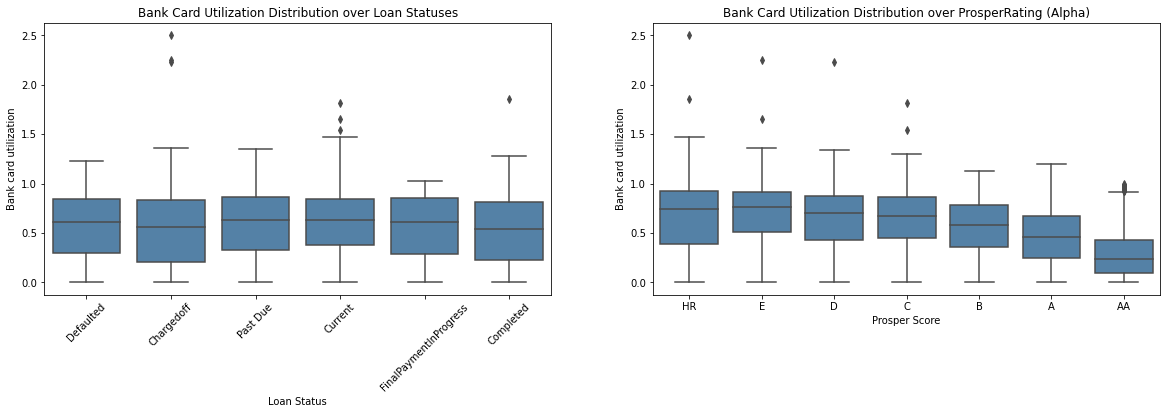

In [72]:
plt.figure(figsize = [20, 5])

plt.subplot(1, 2, 1)
sb.boxplot(data=loans_except_cancelled, 
           x='LoanStatusSimplified', y='BankcardUtilization', color='steelblue');
plt.title('Bank Card Utilization Distribution over Loan Statuses');
plt.ylabel('Bank card utilization')
plt.xlabel('Loan Status')
plt.xticks(rotation=45);

plt.subplot(1, 2, 2)
sb.boxplot(data=loans_except_cancelled, 
           x='ProsperRating (Alpha)', y='BankcardUtilization', color='steelblue');
plt.title('Bank Card Utilization Distribution over ProsperRating (Alpha)');
plt.ylabel('Bank card utilization')
plt.xlabel('Prosper Score');


Surprisingly charged off loans have lower 'BankcardUtilization' mean than completed loans or loans with final payment in progress. However we can see outliers with significantly higher 'BankcardUtilization' for the charged off loans.
However, we can see that bank card utilization  decreases as `ProsperRating (alpha)` increases. 

Next we will plot relationship of 'LoanStatusSimplified' with 'StatedMonthlyIncome'.

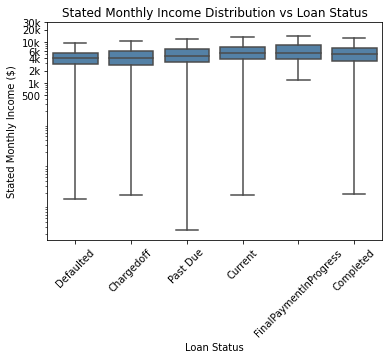

In [73]:
ax = sb.boxplot(data=loans_except_cancelled, x='LoanStatusSimplified',
           y='StatedMonthlyIncome', showfliers = False, color='steelblue');
plt.ylabel('Stated Monthly Income ($)')
plt.xlabel('Loan Status')
plt.yscale('log');
ax.set_yticks([500, 1e3 ,2e3, 4e3, 6e3, 1e4, 2e4, 3e4])
ax.set_yticklabels(['500', '1k', '2k', '4k', '6k', '10k', '20k','30k'])
plt.title('Stated Monthly Income Distribution vs Loan Status')
plt.xticks(rotation=45);

As we can see, that current, completed, and loans with final payment in progress have borrowers that stated monthly income is slightly higher than troublesome loans (defaulted, charged off, past due).

Next I will plot distribution of borrower rate and loan amount to see if there is an interaction with loan status:

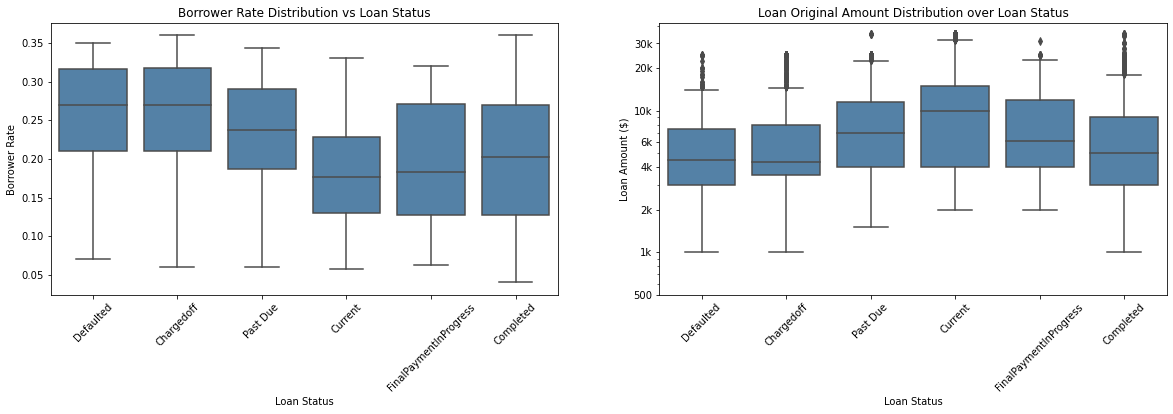

In [74]:
plt.figure(figsize = [20, 5])

plt.subplot(1, 2, 1)
# loan status vs borrower rate box plot
sb.boxplot(data=loans_except_cancelled, x='LoanStatusSimplified', 
           y='BorrowerRate', showfliers = True, color='steelblue');
plt.ylabel('Borrower Rate')
plt.xlabel('Loan Status')
plt.title('Borrower Rate Distribution vs Loan Status')
plt.xticks(rotation=45);

plt.subplot(1, 2, 2)
# loan amount distribution plotted on log scale over loan status break down
ax = sb.boxplot(data=loans_except_cancelled, 
           x='LoanStatusSimplified', y='LoanOriginalAmount', 
           showfliers = True, color='steelblue');
plt.ylabel('Loan Amount ($)')
plt.xlabel('Loan Status')
plt.yscale('log');
ax.set_yticks([500, 1e3 ,2e3, 4e3, 6e3, 1e4, 2e4, 3e4])
ax.set_yticklabels(['500', '1k', '2k', '4k', '6k', '10k', '20k','30k'])
plt.title('Loan Original Amount Distribution over Loan Status' )
plt.xticks(rotation=45);

It seems that Prosper lends more money to current loans compared to the past as mean for past due loans is higher for completed loans but lower than for current loans. 

With regards to relationship between 'BorrowerRate' and loan outcome, we can see that borrower rate on average higher for the loans that defaulted / charged off/ past due compared to current / final payment in progress / completed.

Lastly for this section we will investigate how `ProsperScore` and `ProsperRating (Alpha)` correlate with stated monthly income.
> Note: `ProsperScore` is used as numeric variable here to get ProsperScore mean estimation

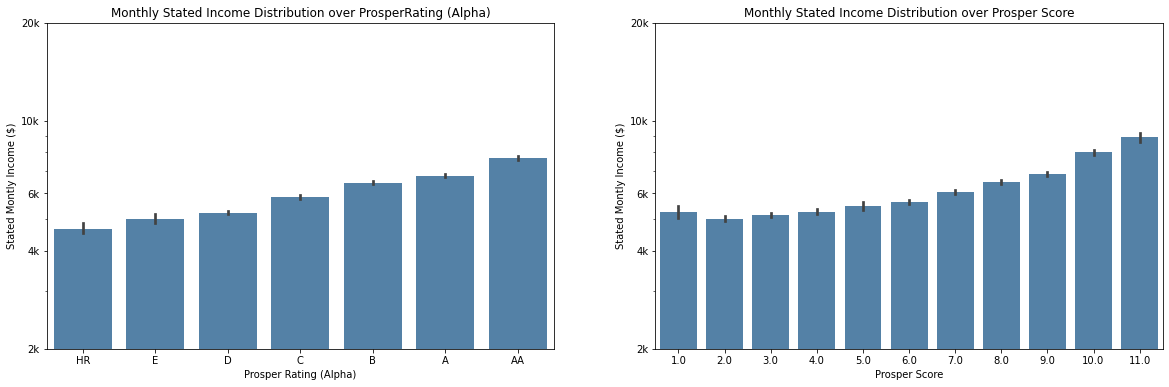

In [75]:
fig, ax = plt.subplots(ncols = 2, figsize = [20,6])

sb.barplot(x='ProsperRating (Alpha)', y="StatedMonthlyIncome",
               data=loans_except_cancelled,
               #palette='vlag_r',
              color='steelblue', ax = ax[0]);
ax[0].set_title('Monthly Stated Income Distribution over ProsperRating (Alpha)')
ax[0].set_ylabel('Stated Montly Income ($)')
ax[0].set_xlabel('Prosper Rating (Alpha)')
ax[0].set_yscale('log')
ax[0].set_yticks([2e3, 4e3, 6e3, 1e4, 2e4])
ax[0].set_yticklabels(['2k', '4k', '6k', '10k','20k'])
ax[0].set_yticklabels([],minor = True);

sb.barplot(x='ProsperScore', y="StatedMonthlyIncome",
            data=loans_except_cancelled,
               #palette='vlag_r',
              color='steelblue', ax = ax[1]);
ax[1].set_title('Monthly Stated Income Distribution over Prosper Score')
ax[1].set_ylabel('Stated Montly Income ($)')
ax[1].set_xlabel('Prosper Score')
ax[1].set_yscale('log')
ax[1].set_yticks([2e3, 4e3, 6e3, 1e4, 2e4])
ax[1].set_yticklabels(['2k', '4k', '6k', '10k','20k'])
ax[1].set_yticklabels([],minor = True);

Stated monthly income has a more clear positive correlation with Prosper Rating (Alpha) compared to Prosper Score.

It can be explained that Prosper Score is calculated by using different set of variables compared to Prosper Rating (Alpha).

Nevertheless, stated monthly income might have indirect influence on a loan outcome as it has direct interaction with Prosper Rating.

I will review this relationship in multi-variate exploration.




### Talk about some of the relationships you observed in this part of the investigation. How did the feature(s) of interest vary with other features in the dataset?

> When looking at the loan status interactions with other variables, I noticed that:
* most loans were given to the borrowers with verifiable income who are employed. However, there is data quality issue as there is a large proportion of loans with no clear distinction of employment status (`EmploymentStatus` = `Other`). 
* most of the defaulted / charged off loans have term 3 years or 5 years. Loans with 1 year term look more successful.
* Loans with `ProsperScore` equal or greater than 8.0 are more likely to be completed. Hence, Prosper scoring system looks reliable.
* loan performance is correlated to the occupation at some degree as some of the occupations outperform others
* loans are not equally distributed among the states with some states have better loan outcome than others. This could be related to the economic reasons such as seasonality and some occupations concentrated in particular states. Thus, loan outcome can correlate to the state and the occupation of the borrower.
* loan category looks related to the outcome of the loan, with 'Debt Consolidation' as top category for total loans. 
* loans that are current, completed, or with final payment in progress have lower borrower rate on average
* stated monthly income looks not being correlated to the loan outcome but could be a relevant factor for the loan originating amount / borrower rate and other factors that can be more correlated with loan outcome.
* number of delinquencies over past years on average is higher for loans that are defaulted / charged off / past due.
* looking at the relationship with loan originating amount, it seems that Prosper tends to lend more money to new loans (status is 'Current') compared to the loans from the past (loans with status other than 'Current')
* interestingly bank card utilization on average looks lower for the charged off loans but not so much different among loans with other statuses; however there are outliers with much higher value than the mean for the charged off loans. 

### Did you observe any interesting relationships between the other features (not the main feature(s) of interest)?

> There are few interesting observations for pair-wise loan variables:
* Borrower rate has a weak negative correlation to stated monthly income
* Borrower rate strongly correlates with `ProsperScore` and `ProsperRating (Numeric)`
* Borrower rate has a strong negative correlation with loan originating amount (as expected)
* `StatedMonthlyIncome` for loans with `ProsperScore` = 1.0 is on average higher than for for loans with `ProsperScore` = 2.0. This can be because Prosper scoring system also assess how the borrower was performing for the past loans and other factors listed here:
https://www.prosper.com/plp/general-prosper_score/

## Multivariate Exploration

> Now I will move to exploration of how loan rating, Prosper score and Prosper rating are related to the loan outcome in conjunction with other variables that we saw related to the loan outcome:
* numerical variables:
    * stated monthly income
    * borrower rate
    * loan originating amount
    * debt-to-income ratio
* categorical variables:
    * loan category
    * employment status

Firstly let's have a look how consistent ratings and scores among all loan outcomes:

### Prosper Score, Prosper Rating, and Loan Rating Consistency

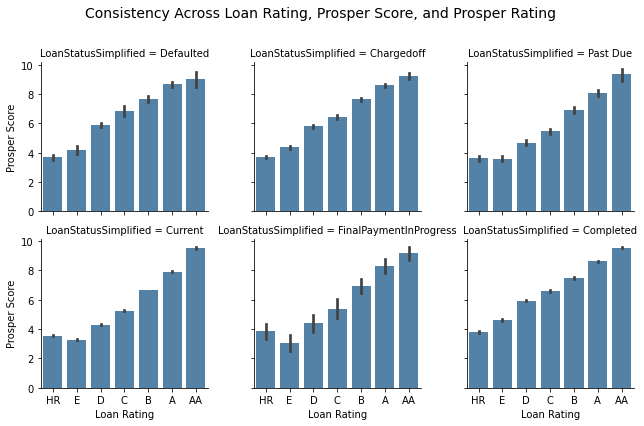

In [76]:
# correlation between prosper score and loan rating - mean estimation
loan_ratings = ['HR','E','D','C','B','A','AA']

g = sb.FacetGrid(data = loans_except_cancelled, col = 'LoanStatusSimplified',#, row = 'ProsperScore',
                 height = 3, margin_titles = False, col_wrap = 3)

g.map(sb.barplot, 'ProsperRating (Alpha)', 'ProsperScore', order = loan_ratings,
      color='steelblue')
g.fig.subplots_adjust(top=0.85)
g.fig.suptitle('Consistency Across Loan Rating, Prosper Score, and Prosper Rating',
              fontsize=14);
g.set_xlabels('Loan Rating')
g.set_ylabels('Prosper Score');
#plt.tight_layout()
#plt.show();

> `ProsperRating (Alpha)` and `ProsperScore` look correlated and consistent across all loan statuses, however it cannot be treated as one-to-one mapping as there is a range of scores for a loan rating value.

> Now let's have a look how consistent Prosper Score, Prosper Rating (numeric) and Loan rating in relation with loan originating amount:

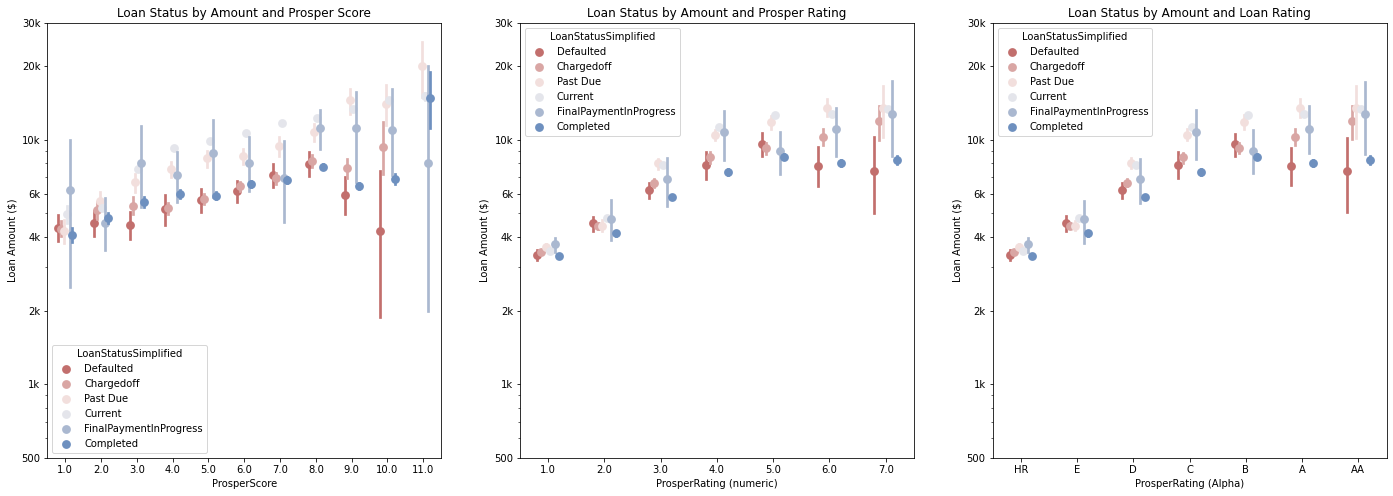

In [77]:
# compare rating and score versus loan originating amount to the loan outcome
fig, ax = plt.subplots(ncols = 3, figsize = [24,8])

sb.pointplot(data = loans_except_cancelled, hue = 'LoanStatusSimplified',
             y = 'LoanOriginalAmount', x = 'ProsperScore',
           palette = 'vlag_r', linestyles = '', dodge = 0.4, ax = ax[0])
ax[0].set_title('Loan Status by Amount and Prosper Score')
ax[0].set_ylabel('Loan Amount ($)')
ax[0].set_yscale('log')
ax[0].set_yticks([500, 1e3 ,2e3, 4e3, 6e3, 1e4, 2e4, 3e4])
ax[0].set_yticklabels(['500', '1k', '2k', '4k', '6k', '10k', '20k','30k'])
ax[0].set_yticklabels([],minor = True)
                       
sb.pointplot(data = loans_except_cancelled, hue = 'LoanStatusSimplified',
             y = 'LoanOriginalAmount', x = 'ProsperRating (numeric)',
           palette = 'vlag_r', linestyles = '', dodge = 0.4, ax = ax[1])
ax[1].set_title('Loan Status by Amount and Prosper Rating')
ax[1].set_ylabel('Loan Amount ($)')
ax[1].set_yscale('log')
ax[1].set_yticks([500, 1e3 ,2e3, 4e3, 6e3, 1e4, 2e4, 3e4])
ax[1].set_yticklabels(['500', '1k', '2k', '4k', '6k', '10k', '20k','30k'])
ax[1].set_yticklabels([],minor = True);
                       
sb.pointplot(data = loans_except_cancelled, hue = 'LoanStatusSimplified',
             y = 'LoanOriginalAmount', x = 'ProsperRating (Alpha)',
           palette = 'vlag_r', linestyles = '', dodge = 0.4, ax = ax[2])
ax[2].set_title('Loan Status by Amount and Loan Rating')
ax[2].set_ylabel('Loan Amount ($)')
ax[2].set_yscale('log')
ax[2].set_yticks([500, 1e3 ,2e3, 4e3, 6e3, 1e4, 2e4, 3e4])
ax[2].set_yticklabels(['500', '1k', '2k', '4k', '6k', '10k', '20k','30k'])
ax[2].set_yticklabels([],minor = True);                       

We can see that `ProsperScore` has more clear relationship with loan originating amount and more clear influence on the loan outcome. 


There is also upward trend for loan originating amount  for higher `ProsperRating (numeric)` and  `ProsperRating (Alpha)` values. 

Another interesting observation here is defaulted/charged off/ past due loans have smaller loan amount when rating or prosper score increases, although deviation can be quite large which signaling about uncertainty that larger loan amount is correlated to the loan outcome for the higher rated loans / loans with higher prosper score.

Nevertheless, `ProsperScore` has the clearest influence on loan outcome by loan originating amount.



### Loan Amount and Prosper Score Influence on Loan Outcome

Let's explore how loan amount is distributed on Prosper Score scale among all loan outcomes:

/Users/olga/opt/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:723: UserWarning: Using the violinplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


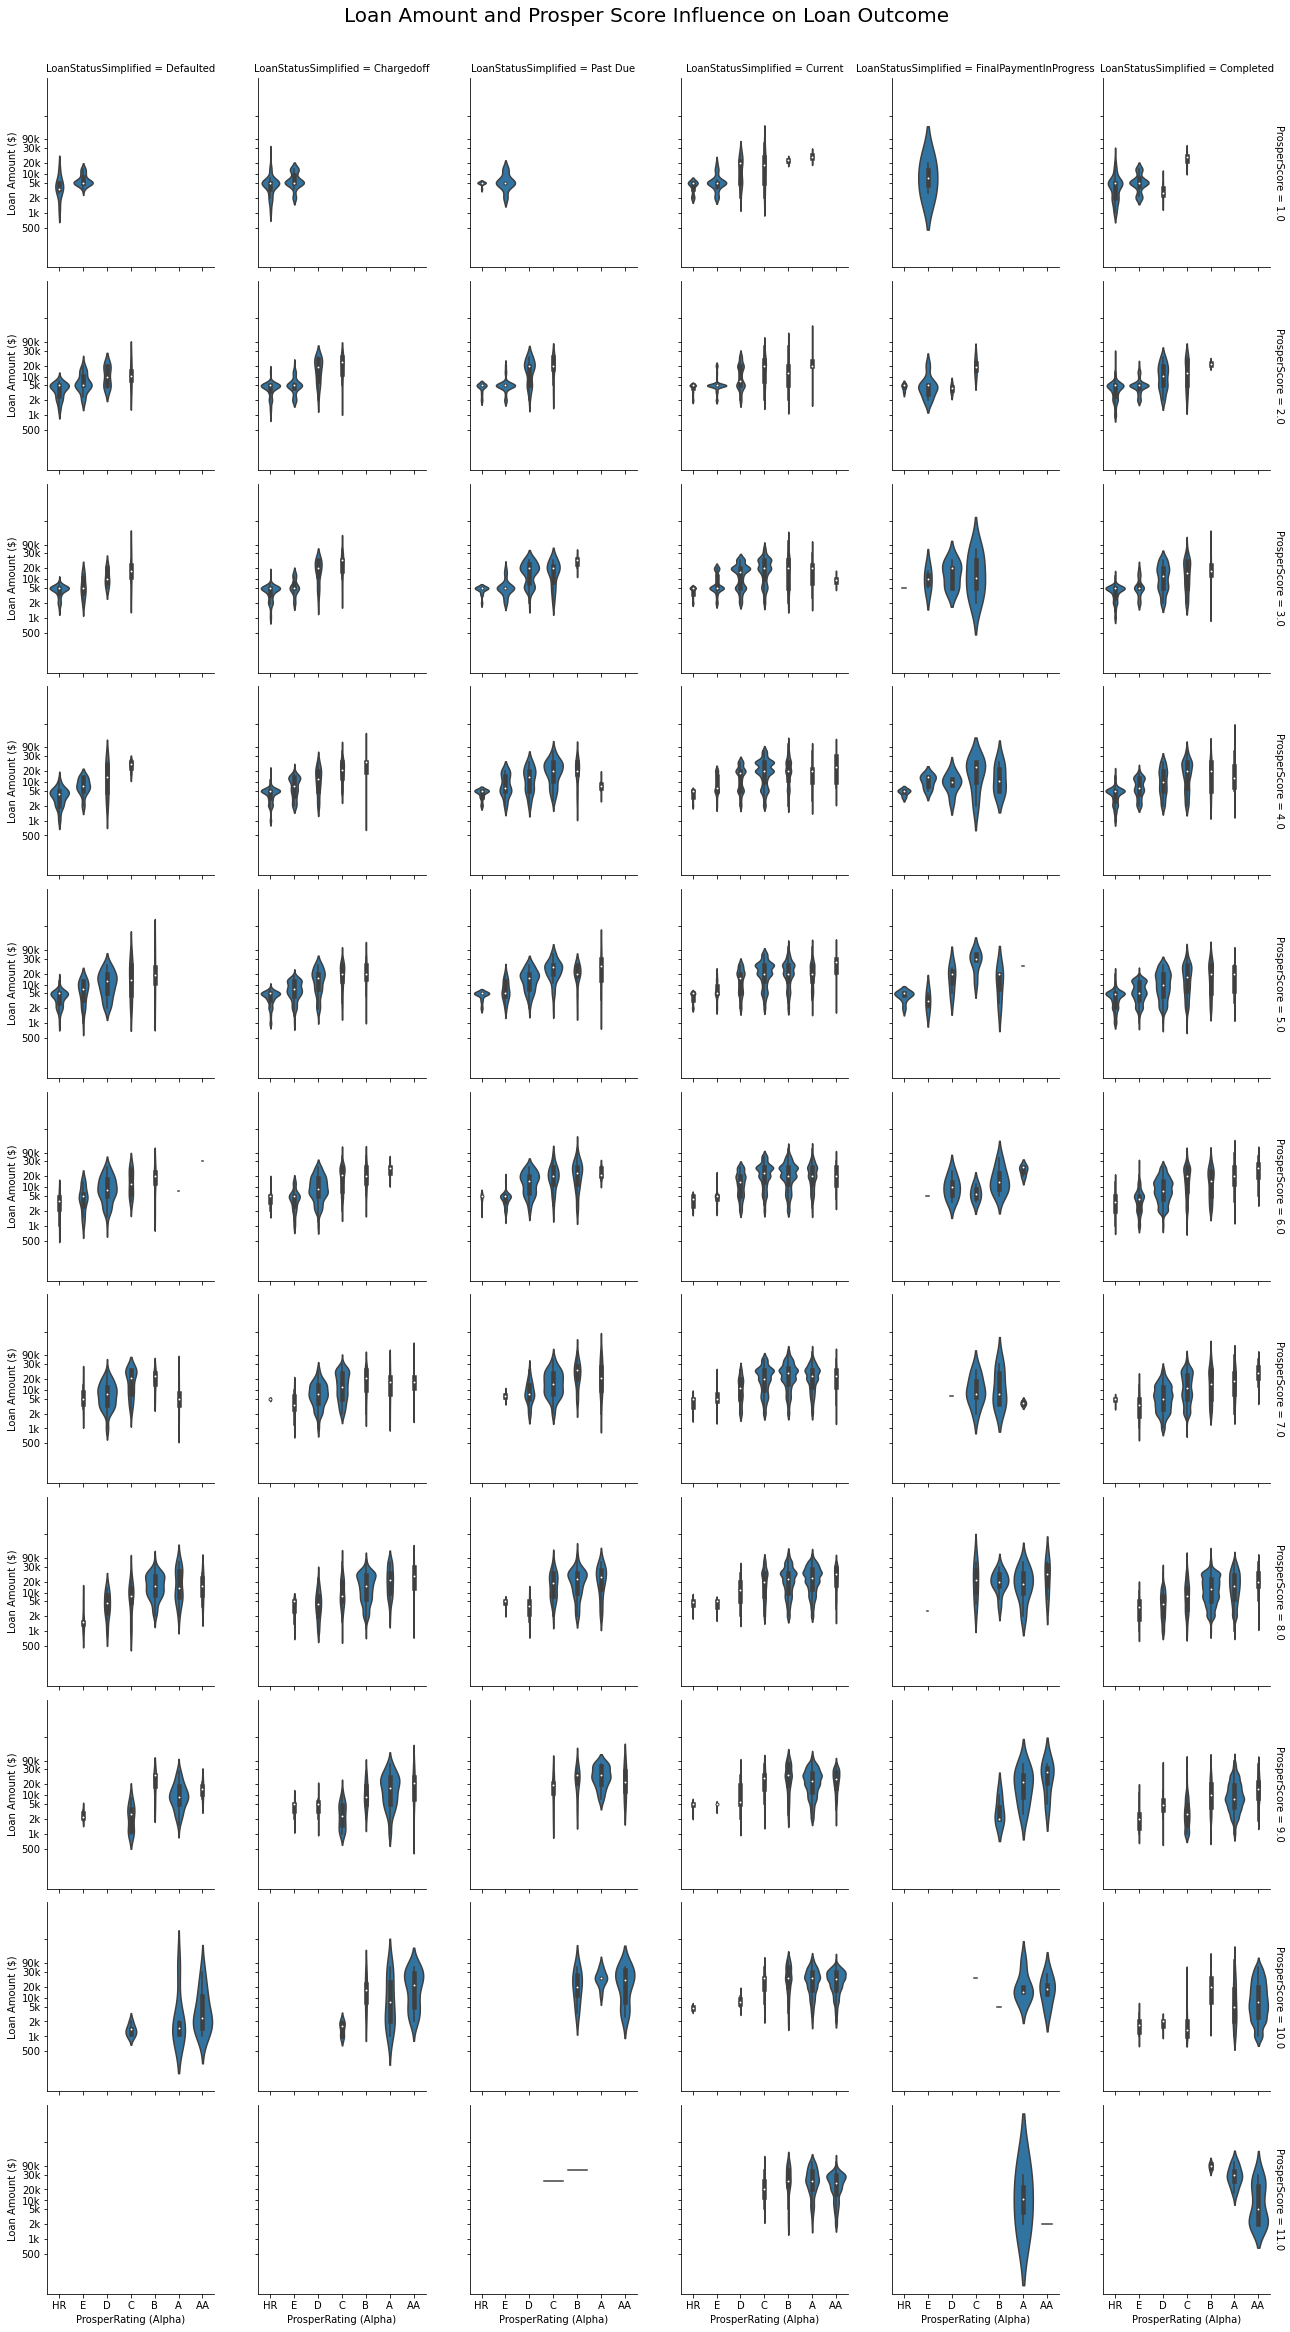

In [78]:
# facet grid to zoom in on loan amount, loan rating, prosper score and loan outcome

prosper_scores = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0]
g = sb.FacetGrid(data = loans_except_cancelled, col = 'LoanStatusSimplified',
                 row = 'ProsperScore',
                 height = 3, margin_titles = True,
                 row_order = prosper_scores)
g.map(sb.violinplot, 'ProsperRating (Alpha)', 'log_loan_amt', scale='count')
g.fig.subplots_adjust(top=0.95)
g.fig.suptitle('Loan Amount and Prosper Score Influence on Loan Outcome',
              fontsize=20);
g.set_xlabels('ProsperRating (Alpha)')
g.set_ylabels('Loan Amount ($)');
plt.yticks(log_trans(np.array([500, 1e3 ,2e3, 4e3, 6e3, 1e4, 2e4, 3e4,9e4])),
               [500, '1k', '2k', '5k', '10k', '20k', '30k', '90k']);


As we can see, loan distribution among loan rating, loan amount, and prosper score across all loan statuses is highly suggested that:
* `ProsperScore` is correlated to `ProsperRating (Alpha)` and loan originating amount
* loan originating amount is higher for lower rated loans ( rating less than B) when `ProsperScore` is also low (less than 8.0)
* loan amount distribution is wider and higher and moving towards higher loan rating (B, A, AA)for the loans with high `ProsperScore` > 8.0


### Stated Monthly Income Influence on Loan Outcome

Next we will explore how stated monthly income can influence loan outcome in conjunction with loan rating or Prosper score.

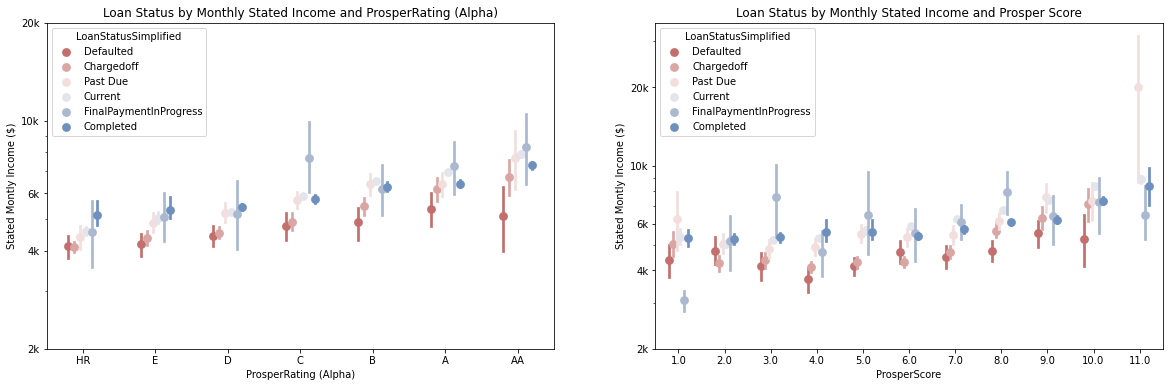

In [79]:
fig, ax = plt.subplots(ncols = 2, figsize = [20,6])

sb.pointplot(data = loans_except_cancelled, hue = 'LoanStatusSimplified',
             y = 'StatedMonthlyIncome', x = 'ProsperRating (Alpha)',
           linestyles = '', dodge = 0.4,
           palette = 'vlag_r', ax = ax[0]);
ax[0].set_title('Loan Status by Monthly Stated Income and ProsperRating (Alpha)')
ax[0].set_ylabel('Stated Montly Income ($)')
ax[0].set_yscale('log')
ax[0].set_yticks([2e3, 4e3, 6e3, 1e4, 2e4])
ax[0].set_yticklabels(['2k', '4k', '6k', '10k','20k'])
ax[0].set_yticklabels([],minor = True);

sb.pointplot(data = loans_except_cancelled, hue = 'LoanStatusSimplified',
             y = 'StatedMonthlyIncome', x = 'ProsperScore',
           linestyles = '', dodge = 0.4,
           palette = 'vlag_r', ax = ax[1]);
ax[1].set_title('Loan Status by Monthly Stated Income and Prosper Score')
ax[1].set_ylabel('Stated Montly Income ($)')
ax[1].set_yscale('log')
ax[1].set_yticks([2e3, 4e3, 6e3, 1e4, 2e4])
ax[1].set_yticklabels(['2k', '4k', '6k', '10k','20k'])
ax[1].set_yticklabels([],minor = True);

>This time stated monthly income is more clearly related to loan rating than Prosper score as we can see that current, final payment in progress or completed loans have higher stated monthly income on average across all ratings.

> Stated monthly income relationship is not as clear with Prosper Score. However we can see that loans with score 11.0 has no defaulted loans.

### Borrower Rate and Prosper Score Influence on Loan Outcome

Next I will explore relationship among borrower rate, loan outcome, and Prosper score.

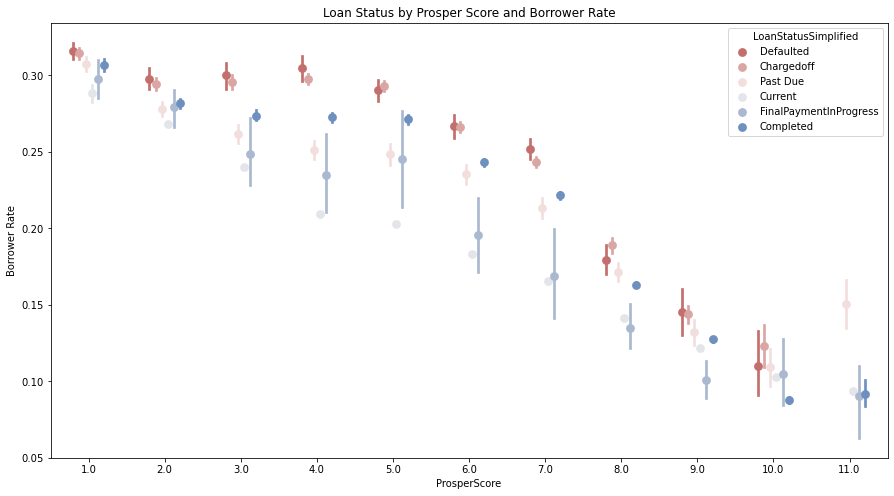

In [80]:
# relationship among borrower rate, loan outcome, and Prosper score
fig = plt.figure(figsize = [15,8])
ax = sb.pointplot(data = loans_except_cancelled, hue = 'LoanStatusSimplified', 
                  y = 'BorrowerRate', x = 'ProsperScore',
           palette = 'vlag_r', linestyles = '', dodge = 0.4)
plt.title('Loan Status by Prosper Score and Borrower Rate')
plt.ylabel('Borrower Rate')
plt.show();

This plot shows clear indication that defaulted  or charged off loans have higher borrower rate on average than loans in other statuses (past due, current, final payment in progress, completed).

We can also see trend for borrower rate being almost always higher for past due loans compared to completed loans (except for Prosper score = 9.0).

As such we can conclude that borrower rate and Prosper score together can influence a loan outcome. 

Now let's have a look how Prosper score and decision on loan amount and borrower rate can be related to a loan outcome:  

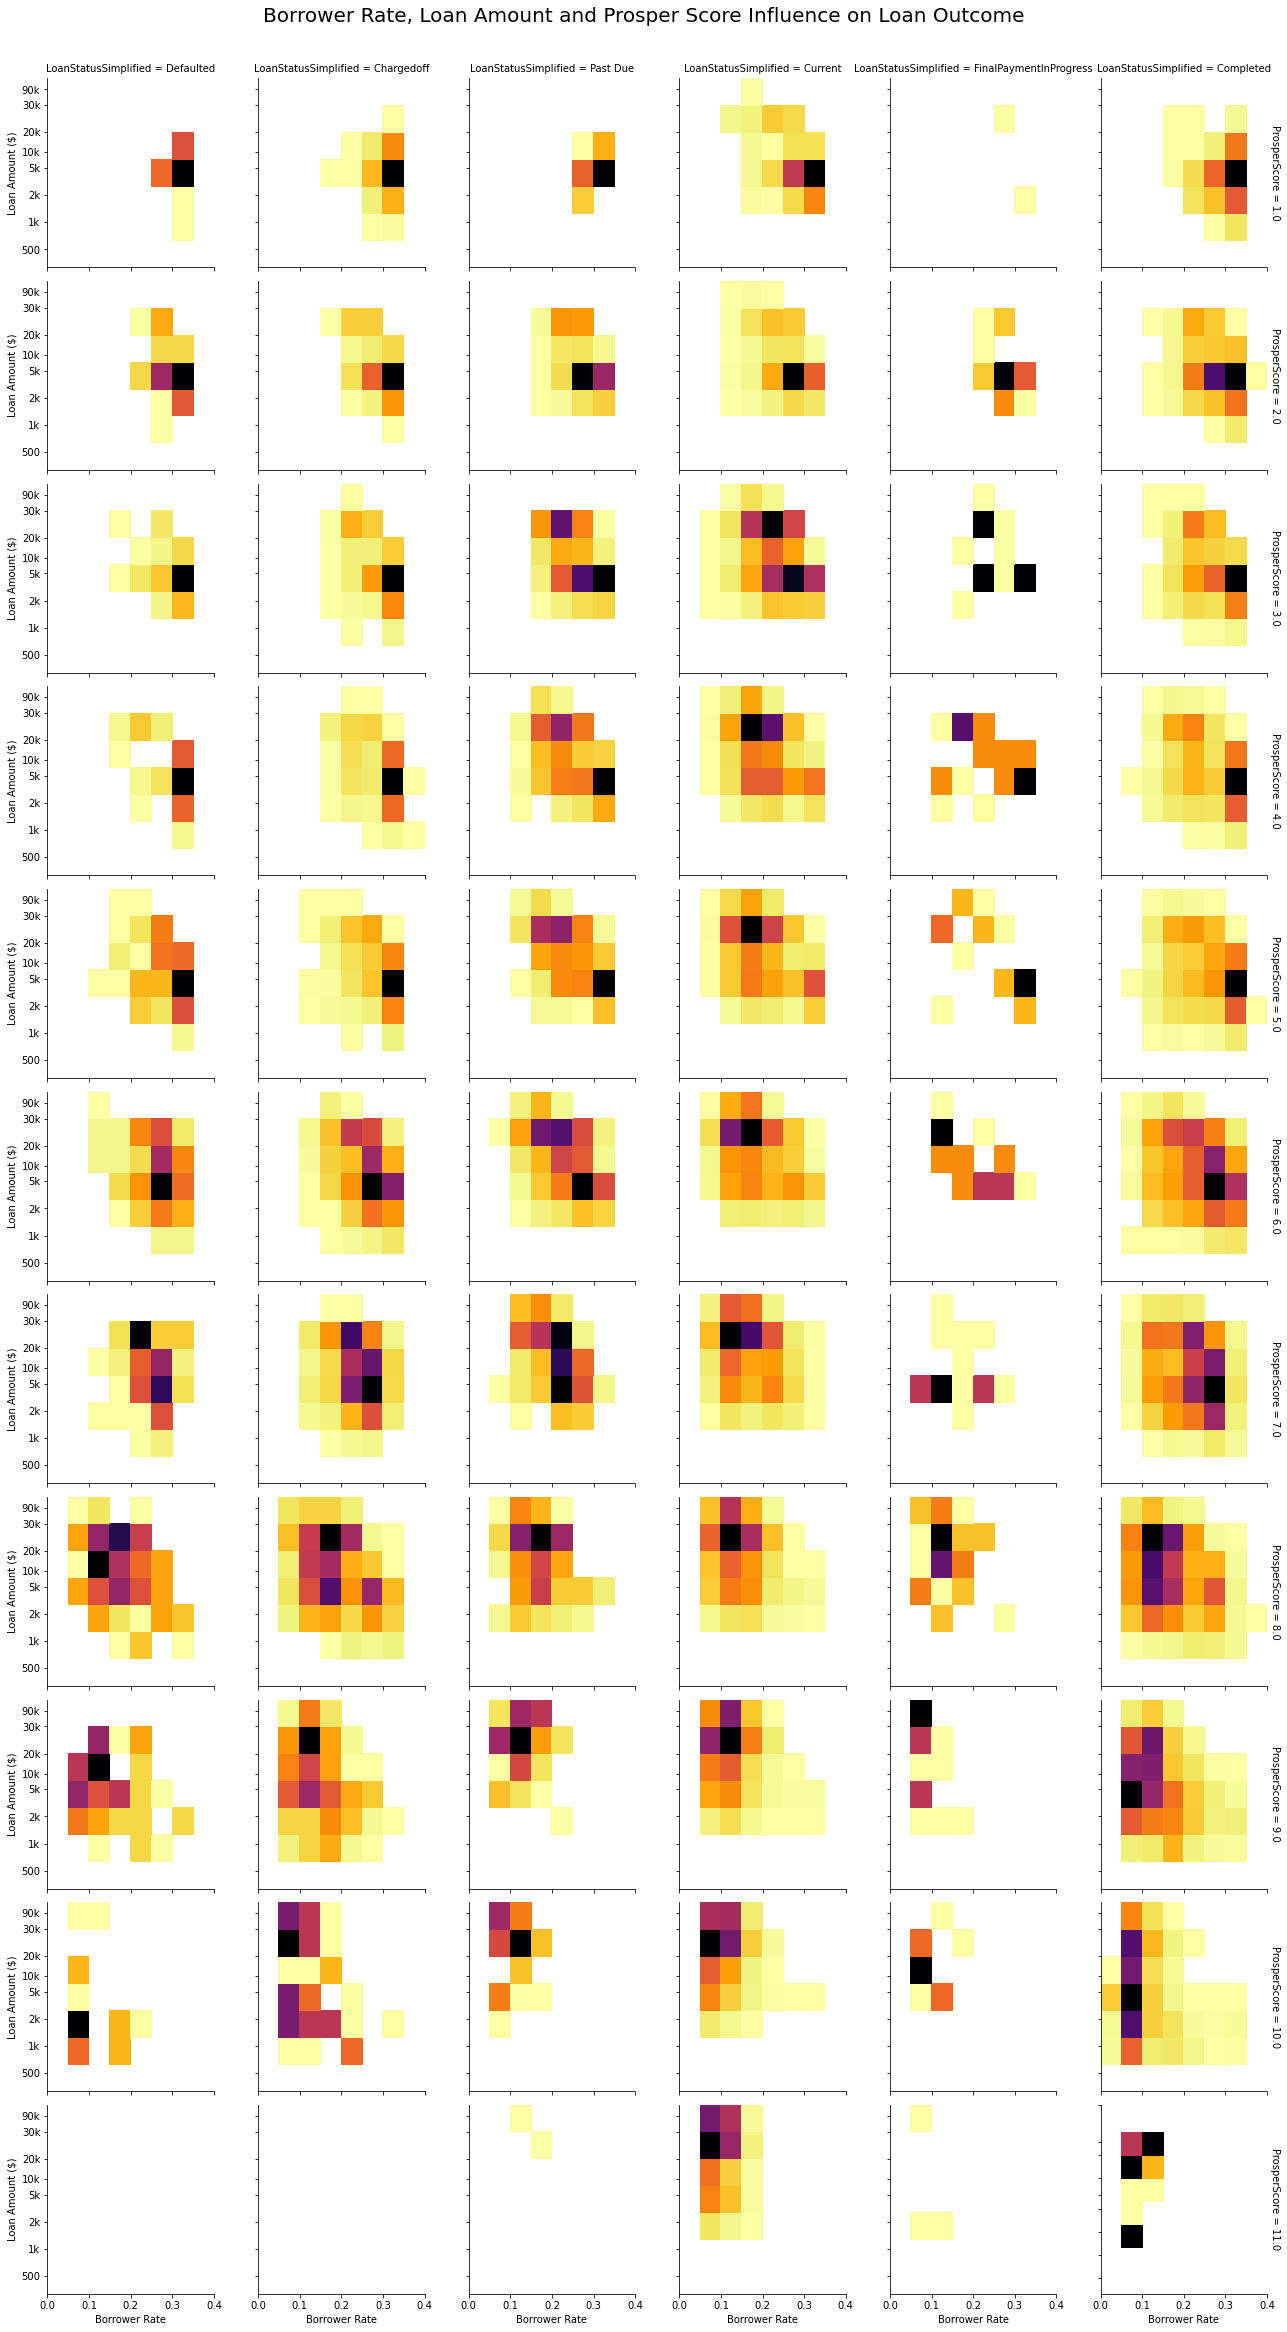

In [81]:
# create faceted heat maps on borrower rate, Prosper Score and loan outcome
g = sb.FacetGrid(data = loans_except_cancelled, col = 'LoanStatusSimplified',
                 row = 'ProsperScore',
                 height = 3, margin_titles = True)
g.map(hist2dgrid, 'BorrowerRate', 'log_loan_amt', color = 'inferno_r')
g.fig.subplots_adjust(top=0.95)
g.fig.suptitle('Borrower Rate, Loan Amount and Prosper Score Influence on Loan Outcome',
              fontsize=20);
g.set_xlabels('Borrower Rate')
g.set_ylabels('Loan Amount ($)');

We can see consistency that loans with higher Prosper Score ( equal or greater than 8.0), borrow rate decreases even for charged off, past due, and defaulted loans.

With regards to loan originating amount, as the `ProsperScore` increases, the 'cloud' of points moves towards the upper left of the plot, thus showing increased loan amount but also smaller borrowing rate.

Again we can see no loans with `ProsperScore` equal to 11 are among defaulted or charged off.

We can also see that as Prosper score increases from 8.0 to 11.0 the 'cloud' of points gets smaller for defaulted / charged off / past due loans but grows for current/ final payment in progress / completed loans.

### Debt-to-income Ratio and Prosper Score Relationship with Loan Outcome
Now let's see if there is a clear relationship among debt-to-income ratio, loan outcome, and Prosper score.  

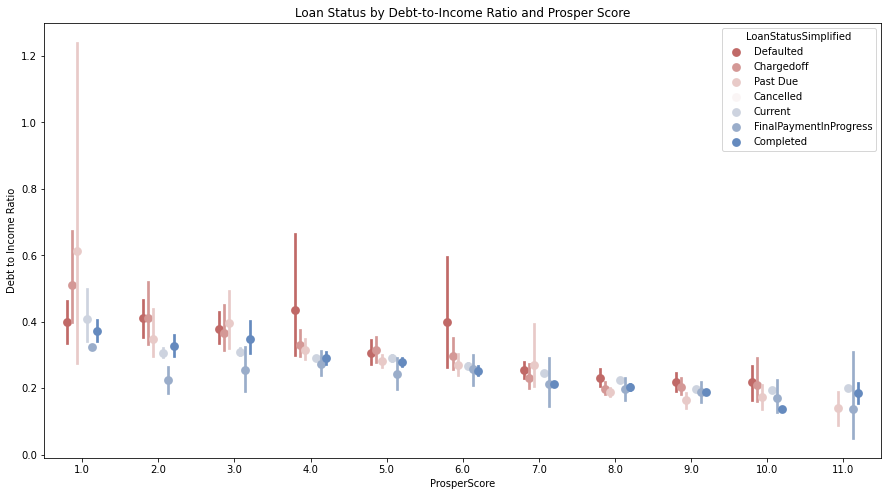

In [82]:
# Debt-to-income Ratio and Prosper Score Relationship with Loan Outcome
fig = plt.figure(figsize = [15,8])
ax = sb.pointplot(data = loans_cleared, hue = 'LoanStatusSimplified',
                  y = 'DebtToIncomeRatio', x = 'ProsperScore',
           palette = 'vlag_r', linestyles = '', dodge = 0.4)
plt.title('Loan Status by Debt-to-Income Ratio and Prosper Score')
plt.ylabel('Debt to Income Ratio');


> We can see that deb-to-income ration is higher for defaulted/charged off/past due loans compared to completed / final payment in progress score with Prosper score <= 7.0.

> Noticeably loans with Prosper score 4.0 and 6.0 have debt-to-income ratio distributed widely with probability going almost as low as completed / final payment in order loans. This observation indicates a greater risk for investors to invest in these loans because of probability of default for these loans can be larger.   

> Therefore, debt-to-income ratio in conjunction with Prosper score shows clear influence on a loan outcome.

### Loan Category and Loan Amount Influence on Loan Outcome

Now let's have a look if loan category can reveal more impact on a loan outcome.
To start with, I will plot mean estimates of loan originating amount across all loan categories and will add hue for loan status.

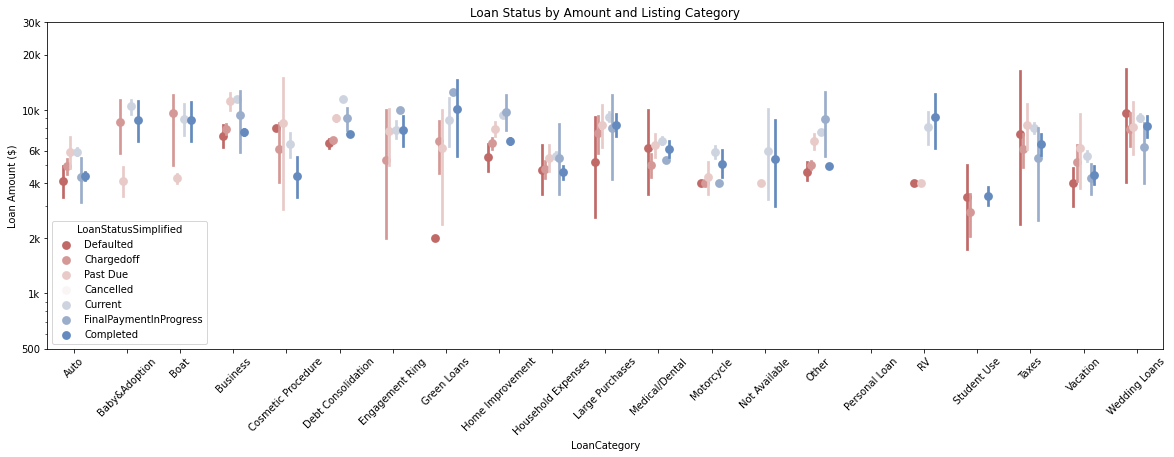

In [83]:
# plot for loan category relationship with loan amount and loan status
fig, ax = plt.subplots(ncols = 1, figsize = [20,6])
sb.pointplot(data = loans_cleared, hue = 'LoanStatusSimplified',
             y = 'LoanOriginalAmount',
             x = 'LoanCategory', palette = 'vlag_r',
             linestyles = '', dodge = 0.4, ax = ax)
ax.set_title('Loan Status by Amount and Listing Category')
ax.set_ylabel('Loan Amount ($)')
ax.set_yscale('log')
ax.set_yticks([500, 1e3 ,2e3, 4e3, 6e3, 1e4, 2e4, 3e4])
ax.set_yticklabels(['500', '1k', '2k', '4k', '6k', '10k', '20k', '30k'])
ax.set_yticklabels([],minor = True)
plt.xticks(rotation = 45);

This plot reveals that loan amount can vary a lot for some categories.
We also see that loan amount for defaulted, charged off, past due can vary a lot for different categories.

However, RV and Green Loans look like top performing loan categories with clear indication that loans with higher loan amount can be more likely repaired.
On the other hand, wedding or taxes loans do not provide certainty that loan will be repaid in time based on the loan amount estimate per loan status and category.  

It can be a good idea to zoom in and plot each category separately across loan status, loan originating amount, and loan rating:

/Users/olga/opt/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:723: UserWarning: Using the violinplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


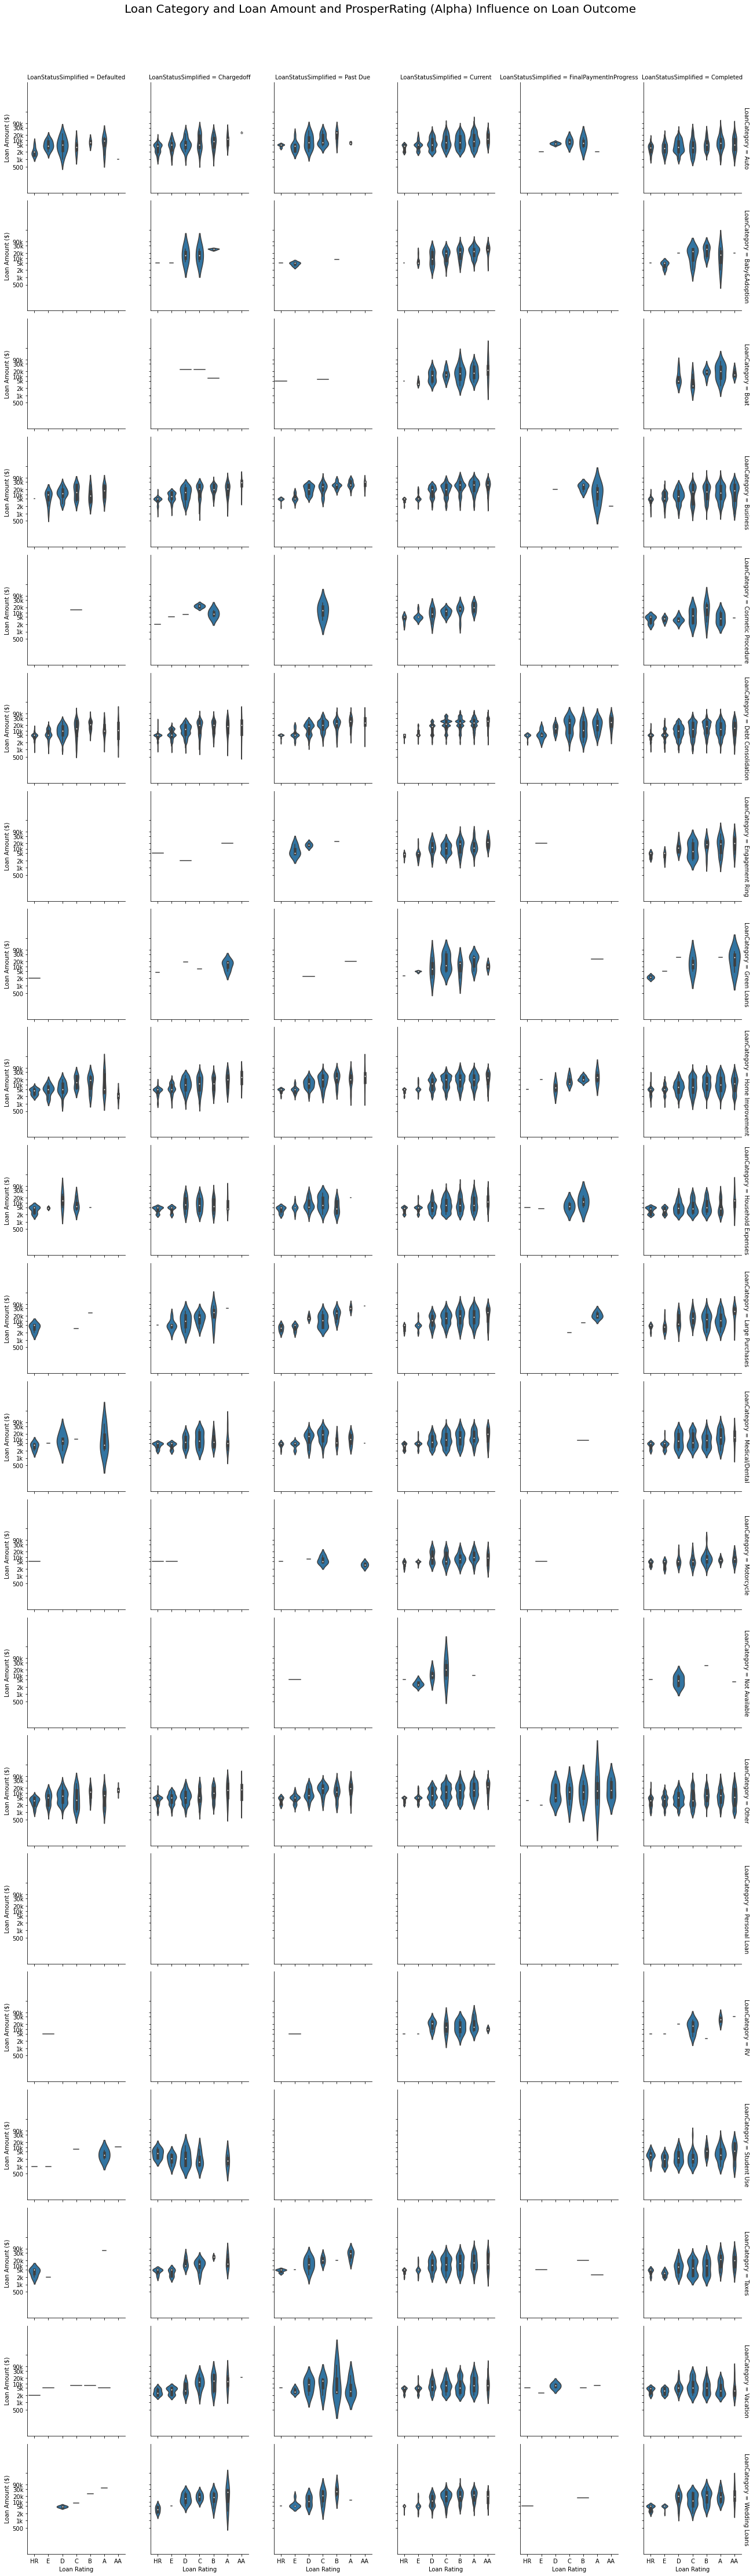

In [84]:
# loan category vs loan rating, loan amount, loan status
#fig = plt.figure(figsize = [20,20])
g = sb.FacetGrid(data = loans_except_cancelled, col = 'LoanStatusSimplified',
                 row = 'LoanCategory',
                 height = 3, margin_titles = True,
                 row_order = loan_categories
                )
g.map(sb.violinplot, 'ProsperRating (Alpha)', 'log_loan_amt', scale='count');
g.set_xlabels('Loan Rating')
g.set_ylabels('Loan Amount ($)');
g.fig.subplots_adjust(top=0.95)
g.fig.suptitle('Loan Category and Loan Amount and ProsperRating (Alpha) Influence on Loan Outcome',
              fontsize=20);
plt.yticks(log_trans(np.array([500, 1e3 ,2e3, 4e3, 6e3, 1e4, 2e4, 3e4,9e4])),
               [500, '1k', '2k', '5k', '10k', '20k', '30k', '90k']);


> Looking at the facets we can see that:
* distribution of loans for each rating differs across loan categories
* there are categories where now well performing loans (defaulted / charged off / past due) are more frequent than completed / final payment in progress loans. Example is Medical/Dental category
* interestingly we can note that vacation loans are more often become past due compared to the completed loans for this category
* there are categories where no defaulted loans detected on the chart such as 'Engagement Ring', 'Baby Adoption', 'Boat'
* There are categories that have loans more frequently completed than charged off. Example: Green Loans

> Overall, the plot confirms that loan category can have influence on a loan outcome.


### Employment Status Influence on Loan Outcome

To start with, I will explore relationship between employment status and Prosper score based on borrower's stated monthly income:

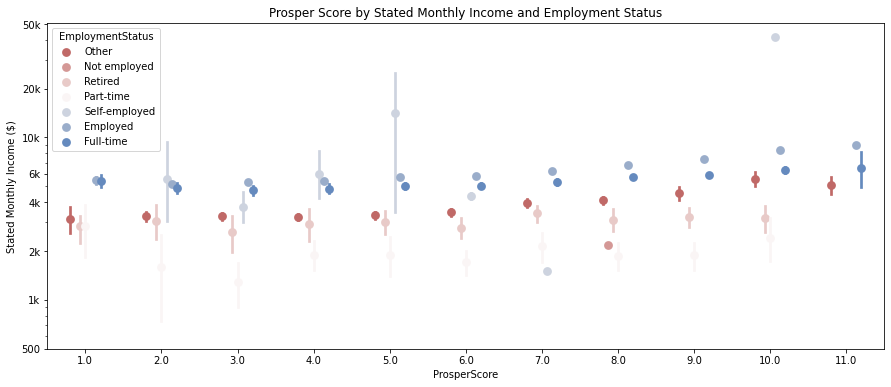

In [85]:
# plot central tendency of stated monthly income across employment status and Prosper score
fig = plt.figure(figsize = [15,6])
ax = sb.pointplot(data = loans_except_cancelled, hue = 'EmploymentStatus',
                  y = 'StatedMonthlyIncome', x = 'ProsperScore',
           palette = 'vlag_r', linestyles = '', dodge = 0.4)
plt.title('Prosper Score by Stated Monthly Income and Employment Status')
plt.ylabel('Stated Monthly Income ($)')
plt.yscale('log')
plt.yticks([500, 1e3 ,2e3, 4e3, 6e3, 1e4, 2e4, 5e4], ['500', '1k', '2k', '4k', '6k', '10k','20k','50k'])
ax.set_yticklabels([],minor = True)
plt.show();

This plot shows that on average self-employed, employed, full-time borrowers earn more than borrowers in `other`, not employed, retired, and part-time categories. 

As such, stated monthly income and employment status are driving Prosper Score which in turn drives loan outcome.

Next, I will explore if some employment groups perform better using loan amount central tendency across employment status and loan outcomes:

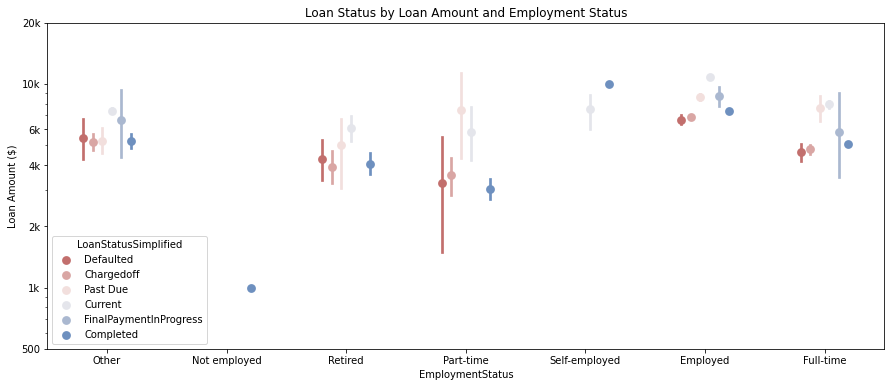

In [86]:
# point plot for employment status, loan amount vs loan outcome
fig = plt.figure(figsize = [15,6])
ax = sb.pointplot(data = loans_except_cancelled, hue = 'LoanStatusSimplified',
                  y = 'LoanOriginalAmount', x = 'EmploymentStatus',
           palette = 'vlag_r', linestyles = '', dodge = 0.4)
plt.title('Loan Status by Loan Amount and Employment Status')
plt.ylabel('Loan Amount ($)')
plt.yscale('log')
plt.yticks([500, 1e3 ,2e3, 4e3, 6e3, 1e4, 2e4], 
           ['500', '1k', '2k', '4k', '6k', '10k','20k'])
ax.set_yticklabels([],minor = True)
plt.show();

This plot reveals interesting observation that part-time employed borrowers can default or miss a payment on a much wider loan amount spread compared to other groups.It makes sense as `ProsperScore (numeric)` has lower rating estimate for part time borrowers compared to other employment groups other than not employed.

Other than that, it is not clear on this particular plot if employment status can drive loan outcome.


### Talk about some of the relationships you observed in this part of the investigation. Were there features that strengthened each other in terms of looking at your feature(s) of interest?

I extended my investigation on Prosper Score and Loan Rating being driving factors in this section. 

The multivariate exploration confirmed that both Prosper Score and Loan Rating are the factors contributing to a loan outcome. I also found that Prosper Rating (numeric) is one of the key factors driving loan outcome.

In addition:
* multivariate exploration confirmed that borrower rate, loan amount are strengthening loan outcome  based on Prosper Score, Loan Rating, Prosper Rating (numeric).
* `Employment Status` in conjunction with `Stated Monthly Income` and `Prosper Score` show more strong correlation with loan outcome than when we looked at these features separately during bivariate and univariate exploration.  
* Debt-to-income ratio in conjunction with Prosper score shows clear influence on a loan outcome.

### Were there any interesting or surprising interactions between features?

There are two very interesting observations noted between loan features during multivariate exploration:
1. Employment Status influence on loan outcome revealed that part-time employed borrowers can default or miss a payment on a much wider loan amount spread compared to other groups. However this employment group has on average smaller Prosper Rating (numeric) so that investors could be aware of higher risk borrowers. 
2. Loan category has non trivial effect on loan outcome; some categories outperforming others with a few not having default loans or having significantly less occurrences for charged off loans.
3. Loans with Prosper score 4.0 and 6.0 have debt-to-income ratio distributed widely with probability going almost as low as completed / final payment in order loans. 